#Datasets used in this project:


1.   Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
2.   Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
3.   Surrey Audio-Visual Expressed Emotion (Savee)
4.   Toronto emotional speech set (Tess)





*   https://www.kaggle.com/datasets/ejlok1/cremad
*   https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
*   https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
*   https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess




# Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing and processing audio signals.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# allows you to embed audio content directly in your notebook
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Importing Data


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# %cd /content/drive/MyDrive/Audio Analysis
%cd /content/drive/MyDrive/Mahdi_Javadi/Audio Analysis

/content/drive/.shortcut-targets-by-id/1RJ2iykdSr1QmuRg6E7eO50_MSQuHmEGd/Audio Analysis


In [ ]:
# Get the current working directory
cwd = os.getcwd()

# Get a list of all the files and directories in the current working directory
contents = os.listdir(cwd)

# Print the list of contents
print(contents)

['SAVEE', 'CREMA-D', 'RAVDESS', 'TESS', 'Audio_Speech_Sentiment', 'Models', 'data_path.csv', 'features.csv', 'wave2vec', 'best_model.h5', 'app.py']


# Data

To prepare the data for our model training, I will create a dataframe that includes all the emotions from the four datasets along with their respective file paths. This dataframe will be utilized to extract the necessary features for training our model.

In [ ]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/Audio Analysis/RAVDESS/audio_speech_actors_01-24/"
Crema = "/content/drive/MyDrive/Audio Analysis/CREMA-D/AudioWAV/"
Tess = "/content/drive/MyDrive/Audio Analysis/TESS/TESS Toronto emotional speech set data/"
Savee = "/content/drive/MyDrive/Audio Analysis/SAVEE/ALL/"


1. Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:



*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).






Here's an example of an audio filename in the RAVDESS dataset:

03-02-04-02-02-02-20.wav

This filename indicates the following metadata for the audio file:

Modality: Audio-only (03)
Vocal channel: Song (02)
Emotion: Sad (04)
Emotional intensity: Strong (02)
Statement: "Dogs are sitting by the door" (02)
Repetition: 2nd repetition (02)
Actor: 20th actor (20) - Male (as the actor ID number is odd)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0      sad  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
1      sad  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
2    angry  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
3    angry  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
4     calm  /content/drive/MyDrive/Audio Analysis/RAVDESS/...

╒════╤════════════╤═════════╕
│    │ Emotions   │   Count │
╞════╪════════════╪═════════╡
│  0 │ sad        │     192 │
├────┼────────────┼─────────┤
│  1 │ angry      │     192 │
├────┼────────────┼─────────┤
│  2 │ calm       │     192 │
├────┼────────────┼─────────┤
│  3 │ happy      │     192 │
├────┼────────────┼─────────┤
│  4 │ disgust    │     192 │
├────┼────────────┼─────────┤
│  5 │ fear       │     192 │
├────┼────────────┼─────────┤
│  6 │ surprise   │     192 │
├────┼────────────┼─────────┤
│  7 │ neutral    │      96 │
├────┼────────────┼─────────┤
│  8 │ Total      │    1440 │
╘════╧════════════╧═════════╛


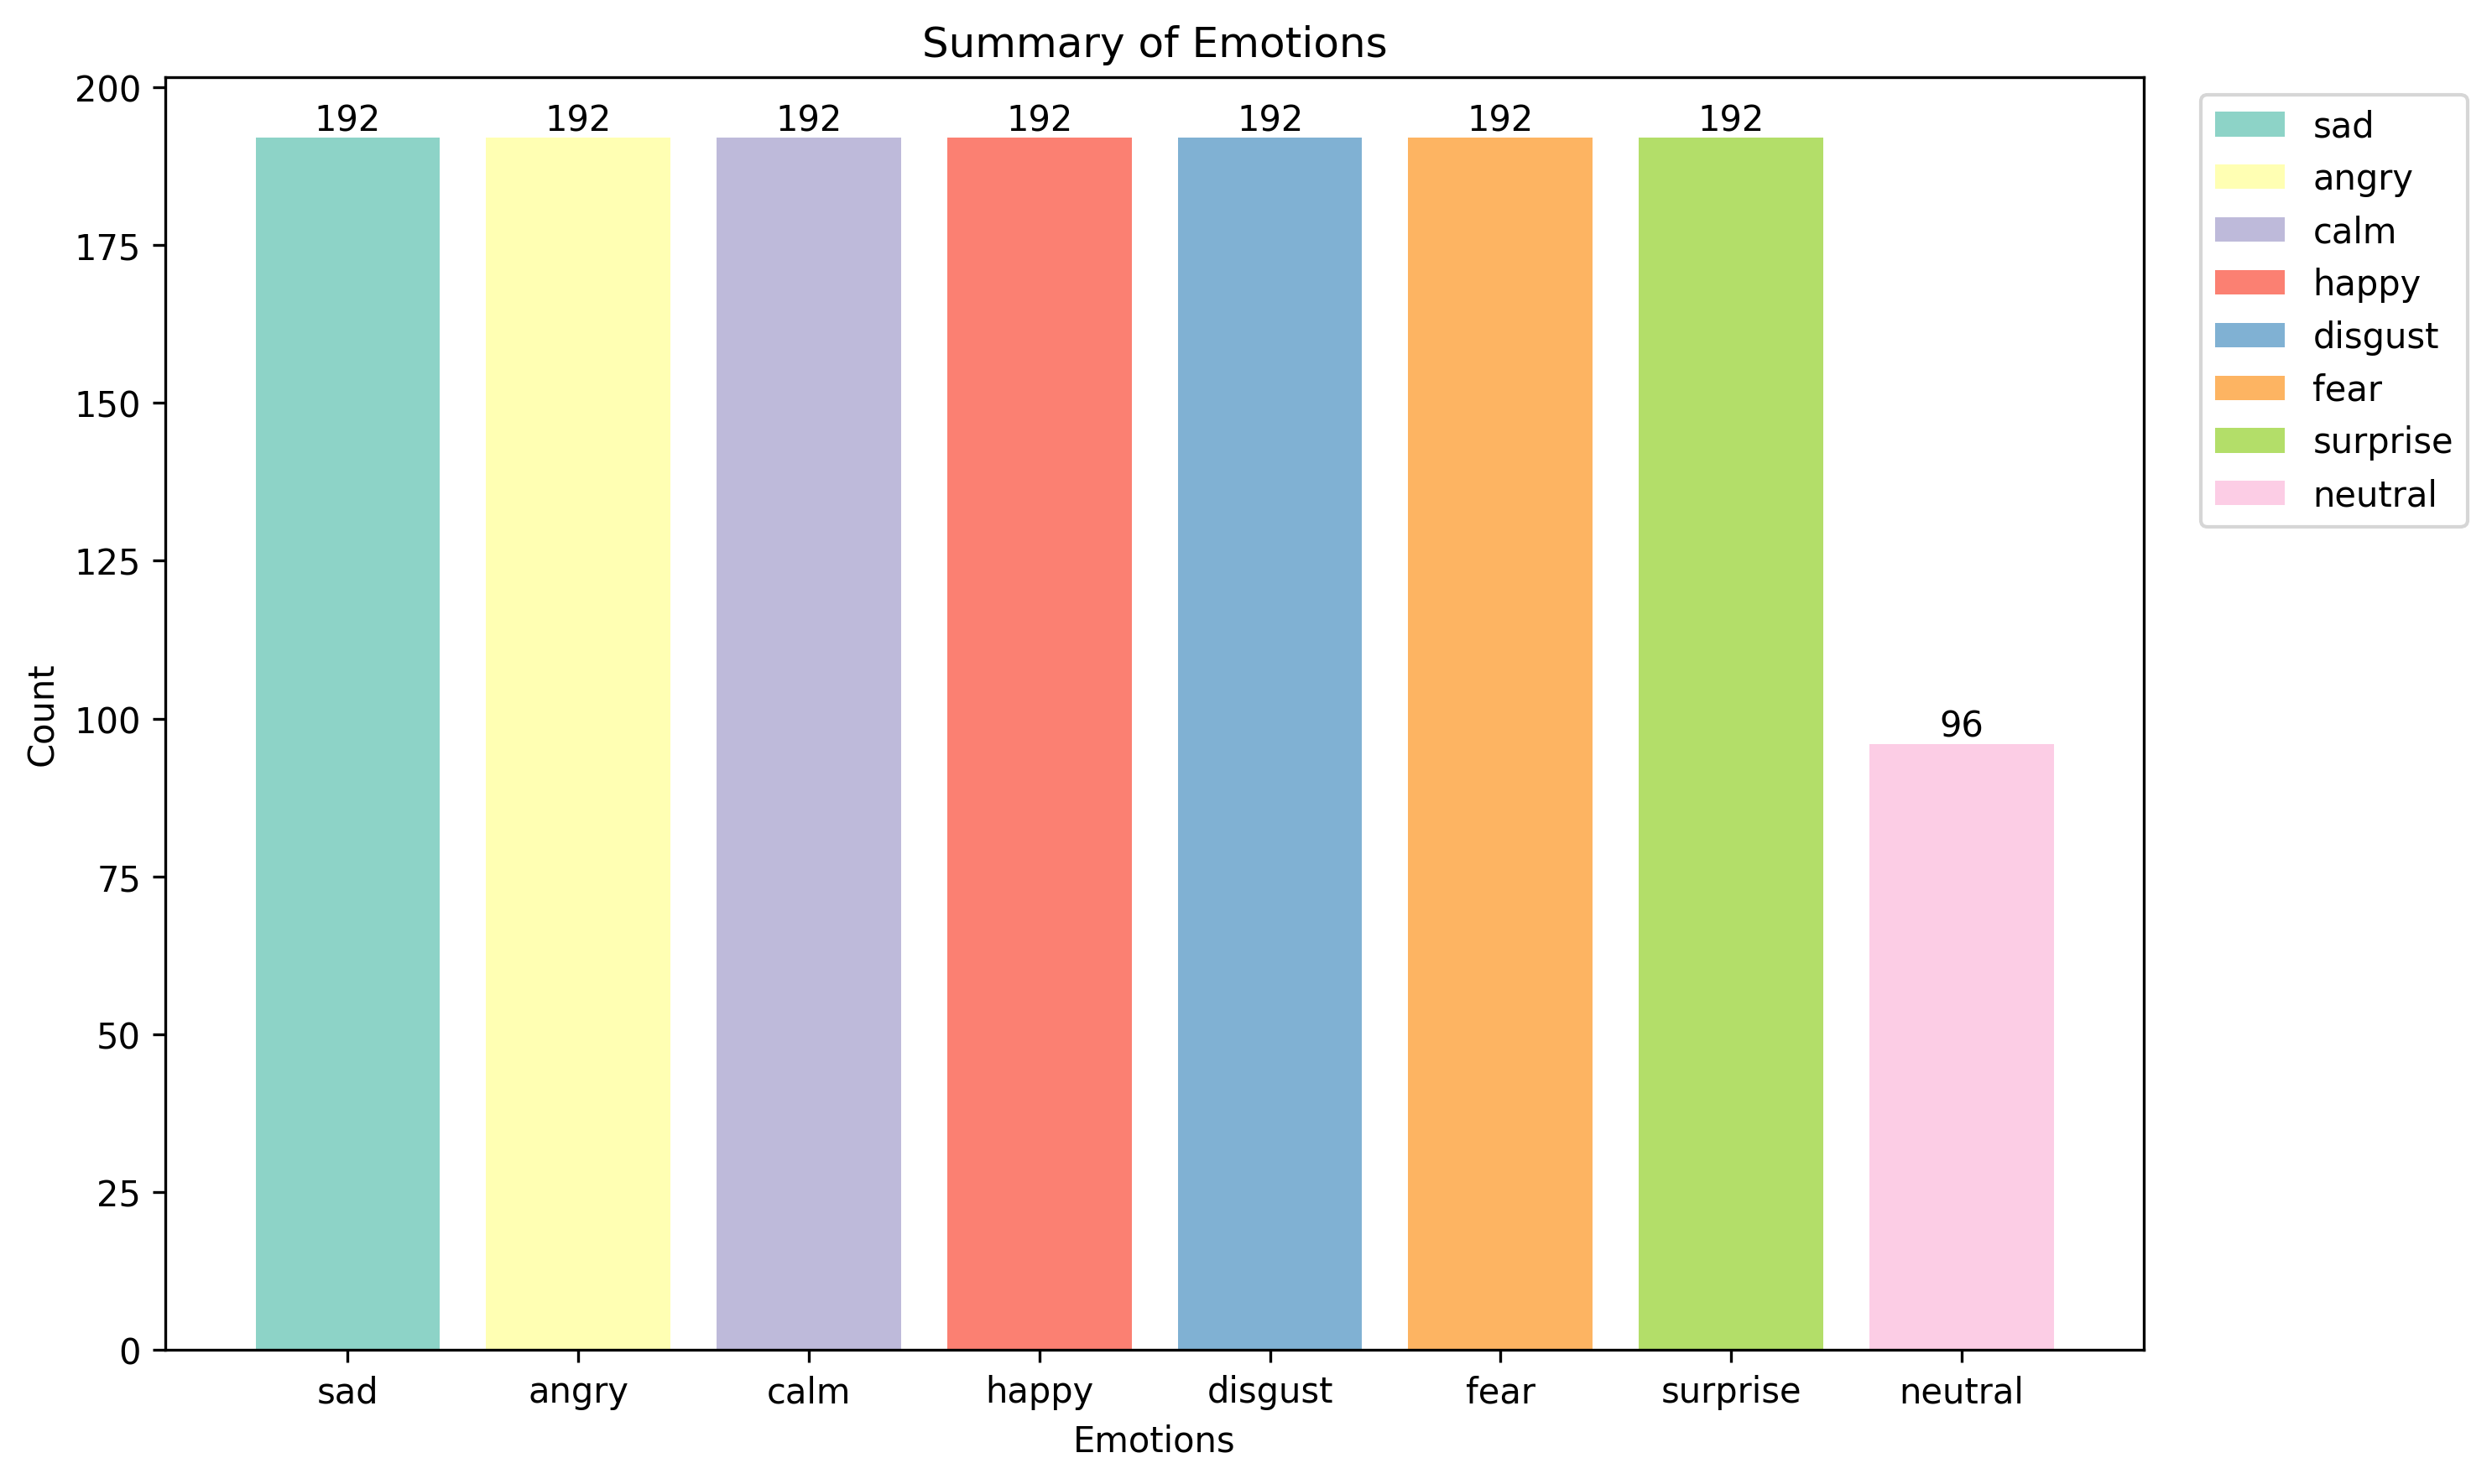

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# Define color palette
color_palette = plt.get_cmap('Set3')

# Compute emotion summary
emotion_summary = Ravdess_df['Emotions'].value_counts().reset_index()
emotion_summary.columns = ['Emotions', 'Count']

# Compute summation row
summation_row = pd.DataFrame({'Emotions': ['Total'], 'Count': [emotion_summary['Count'].sum()]})

# Display emotion summary as a table
emotion_summary_with_total = pd.concat([emotion_summary, summation_row], ignore_index=True)
table = tabulate(emotion_summary_with_total, headers='keys', tablefmt='fancy_grid')
print(table)

# Create high-resolution bar plot with color assignment and labels
plt.figure(figsize=(10, 6), dpi=300)
bars = plt.bar(emotion_summary['Emotions'], emotion_summary['Count'], color=color_palette(np.arange(len(emotion_summary))))
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Summary of Emotions')

# Add color legend
legend_labels = emotion_summary['Emotions'].tolist()
plt.legend(bars, legend_labels)

# Add labels to each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(emotion_summary['Count'][i]), ha='center', va='bottom')


# Move the legend to a better position
plt.legend(bars, emotion_summary['Emotions'], bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


2. Crema DataFrame

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  neutral  /content/drive/MyDrive/Audio Analysis/CREMA-D/...
1    happy  /content/drive/MyDrive/Audio Analysis/CREMA-D/...
2      sad  /content/drive/MyDrive/Audio Analysis/CREMA-D/...
3  neutral  /content/drive/MyDrive/Audio Analysis/CREMA-D/...
4    angry  /content/drive/MyDrive/Audio Analysis/CREMA-D/...

<ipython-input-9-eeb74a438926>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)


╒════╤════════════╤═════════╕
│    │ Emotions   │   Count │
╞════╪════════════╪═════════╡
│  0 │ happy      │    1271 │
├────┼────────────┼─────────┤
│  1 │ sad        │    1271 │
├────┼────────────┼─────────┤
│  2 │ angry      │    1271 │
├────┼────────────┼─────────┤
│  3 │ fear       │    1271 │
├────┼────────────┼─────────┤
│  4 │ disgust    │    1271 │
├────┼────────────┼─────────┤
│  5 │ neutral    │    1087 │
├────┼────────────┼─────────┤
│  6 │ Total      │    7442 │
╘════╧════════════╧═════════╛


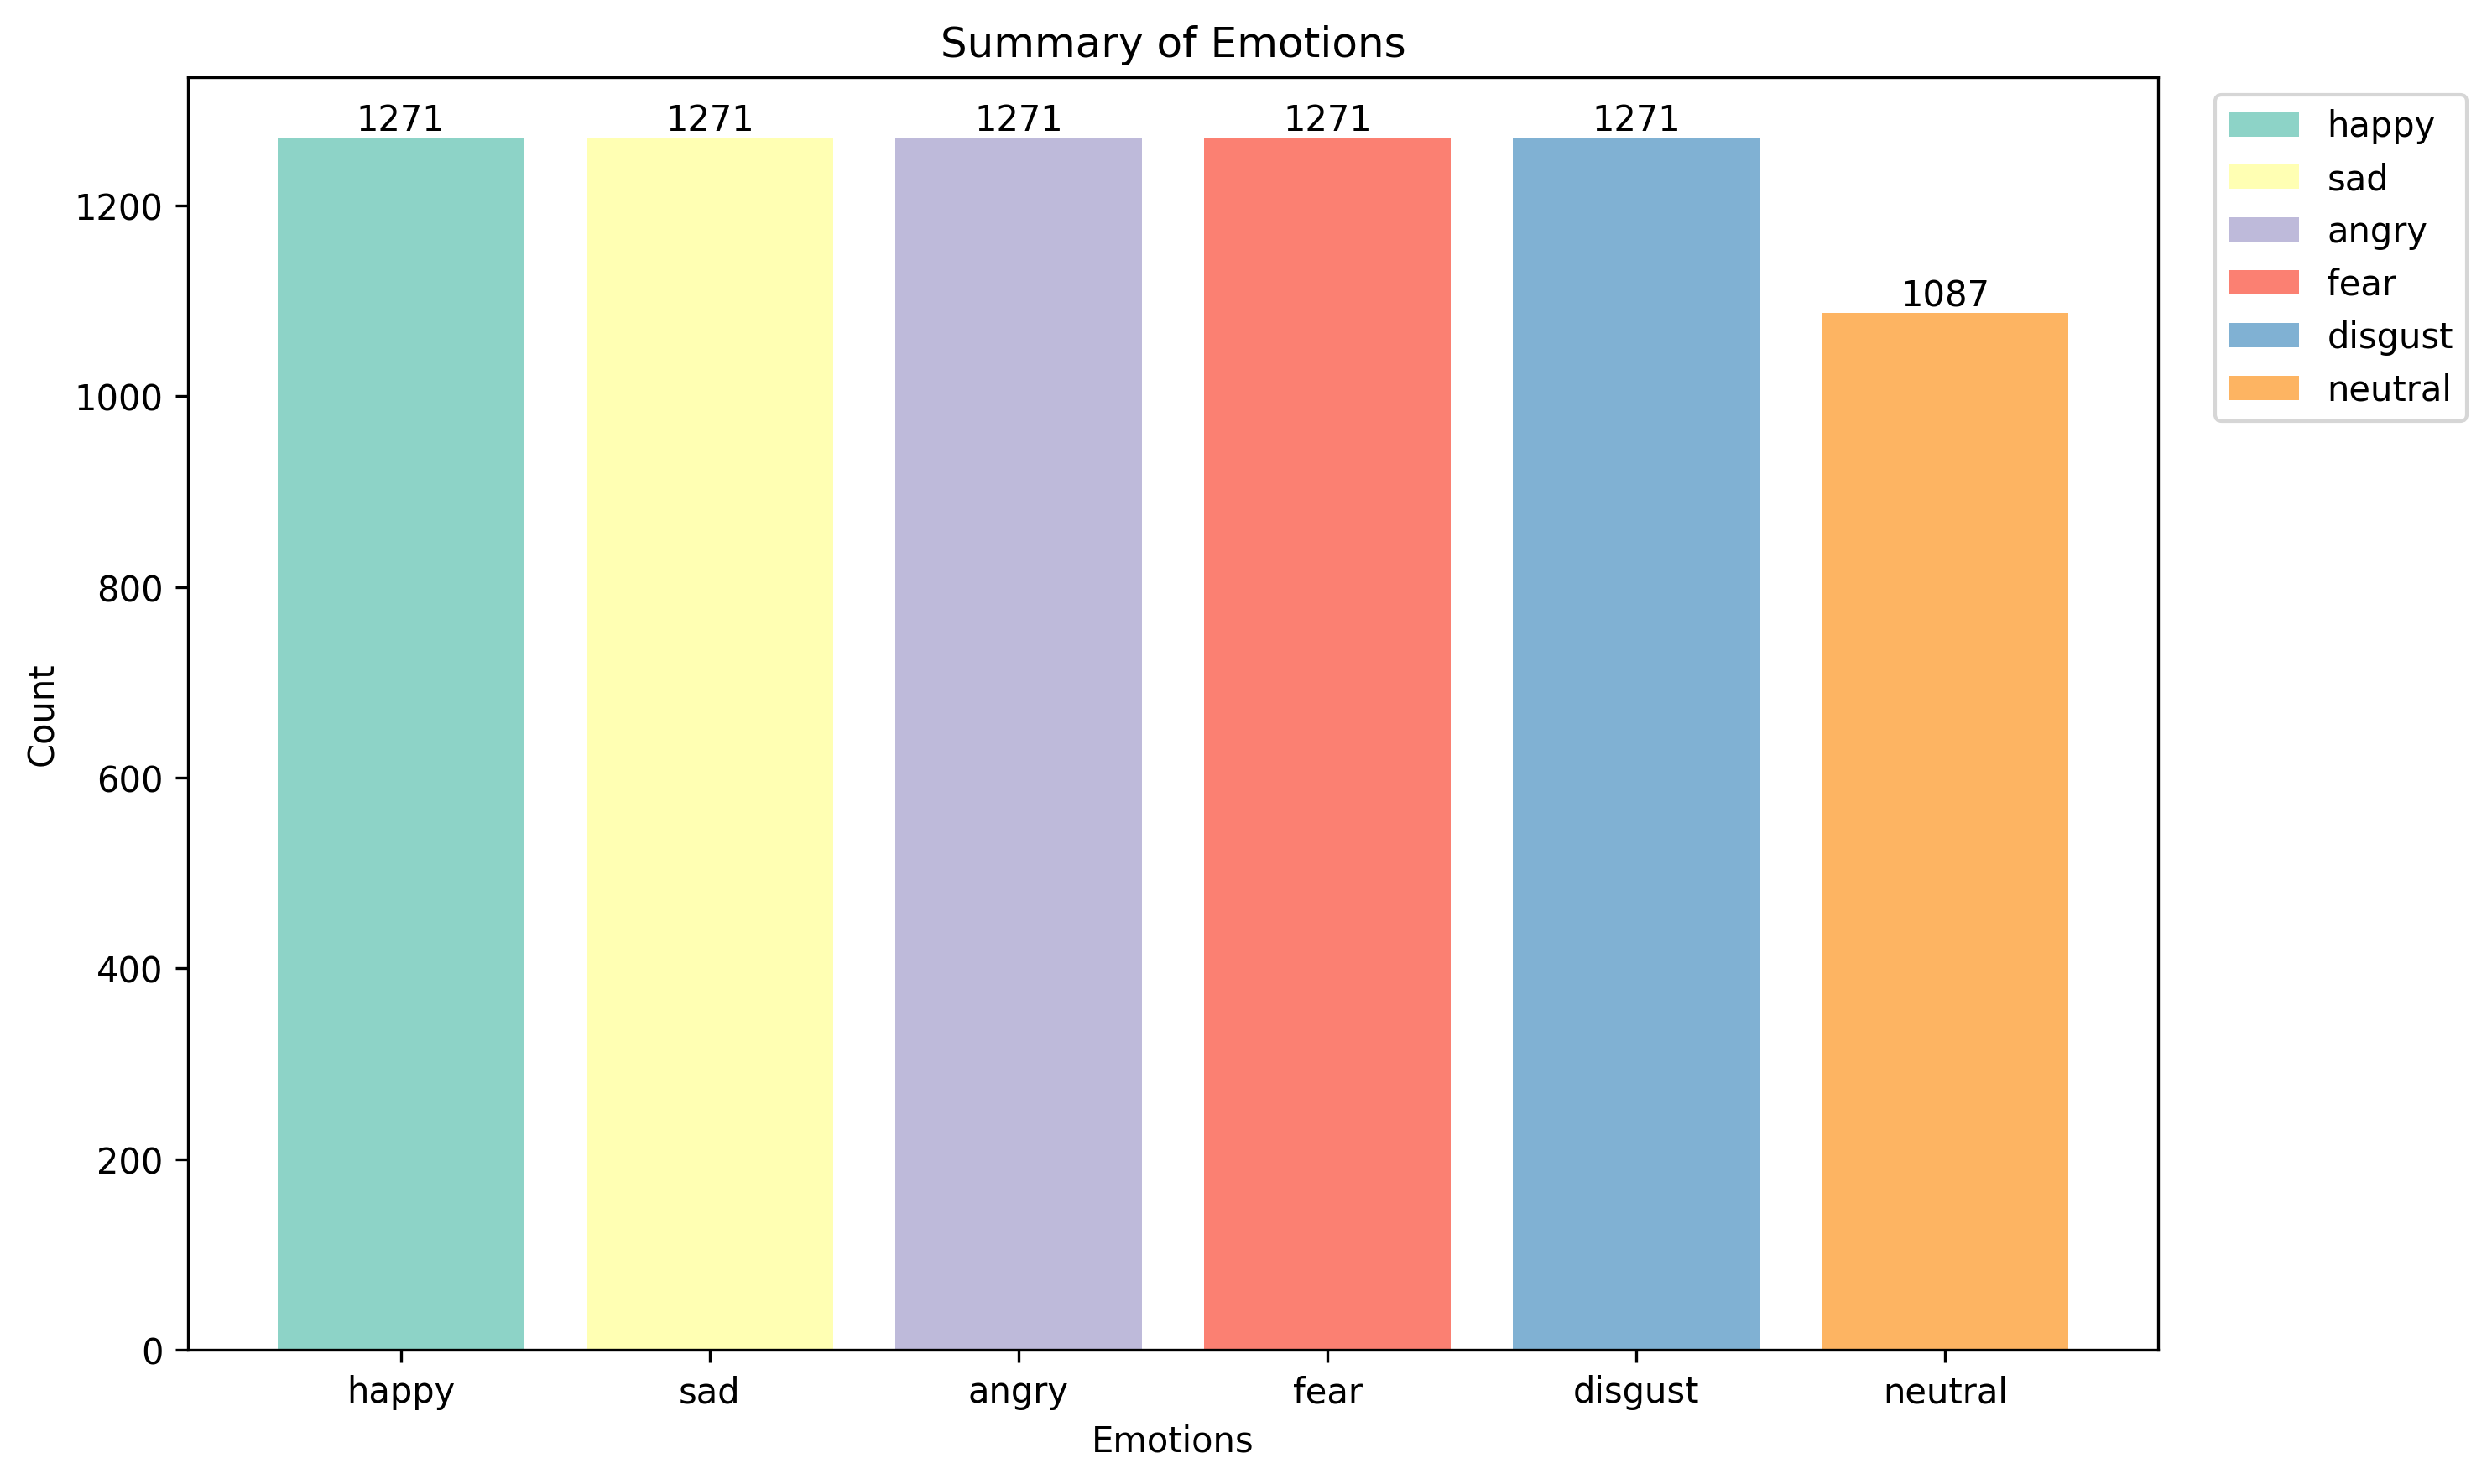

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# Compute emotion summary
emotion_summary = Crema_df['Emotions'].value_counts().reset_index()
emotion_summary.columns = ['Emotions', 'Count']

# Compute total
total = emotion_summary['Count'].sum()

# Add summation row to the emotion summary
emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)

# Display emotion summary as a table with total
table = tabulate(emotion_summary_with_total, headers='keys', tablefmt='fancy_grid')
print(table)

# Create high-resolution bar plot with color assignment and labels
plt.figure(figsize=(10, 6), dpi=300)
color_palette = plt.get_cmap('Set3')
bars = plt.bar(emotion_summary['Emotions'], emotion_summary['Count'], color=color_palette(np.arange(len(emotion_summary))))
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Summary of Emotions')

# Add labels to each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(emotion_summary['Count'][i]), ha='center', va='bottom')

# Move the legend to a better position
plt.legend(bars, emotion_summary['Emotions'], bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


3. TESS dataset

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  /content/drive/MyDrive/Audio Analysis/TESS/TES...
1    angry  /content/drive/MyDrive/Audio Analysis/TESS/TES...
2    angry  /content/drive/MyDrive/Audio Analysis/TESS/TES...
3    angry  /content/drive/MyDrive/Audio Analysis/TESS/TES...
4    angry  /content/drive/MyDrive/Audio Analysis/TESS/TES...

<ipython-input-11-20dcb01bad94>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)


╒════╤════════════╤═════════╕
│    │ Emotions   │   Count │
╞════╪════════════╪═════════╡
│  0 │ angry      │     400 │
├────┼────────────┼─────────┤
│  1 │ disgust    │     400 │
├────┼────────────┼─────────┤
│  2 │ fear       │     400 │
├────┼────────────┼─────────┤
│  3 │ happy      │     400 │
├────┼────────────┼─────────┤
│  4 │ neutral    │     400 │
├────┼────────────┼─────────┤
│  5 │ surprise   │     400 │
├────┼────────────┼─────────┤
│  6 │ sad        │     400 │
├────┼────────────┼─────────┤
│  7 │ Total      │    2800 │
╘════╧════════════╧═════════╛


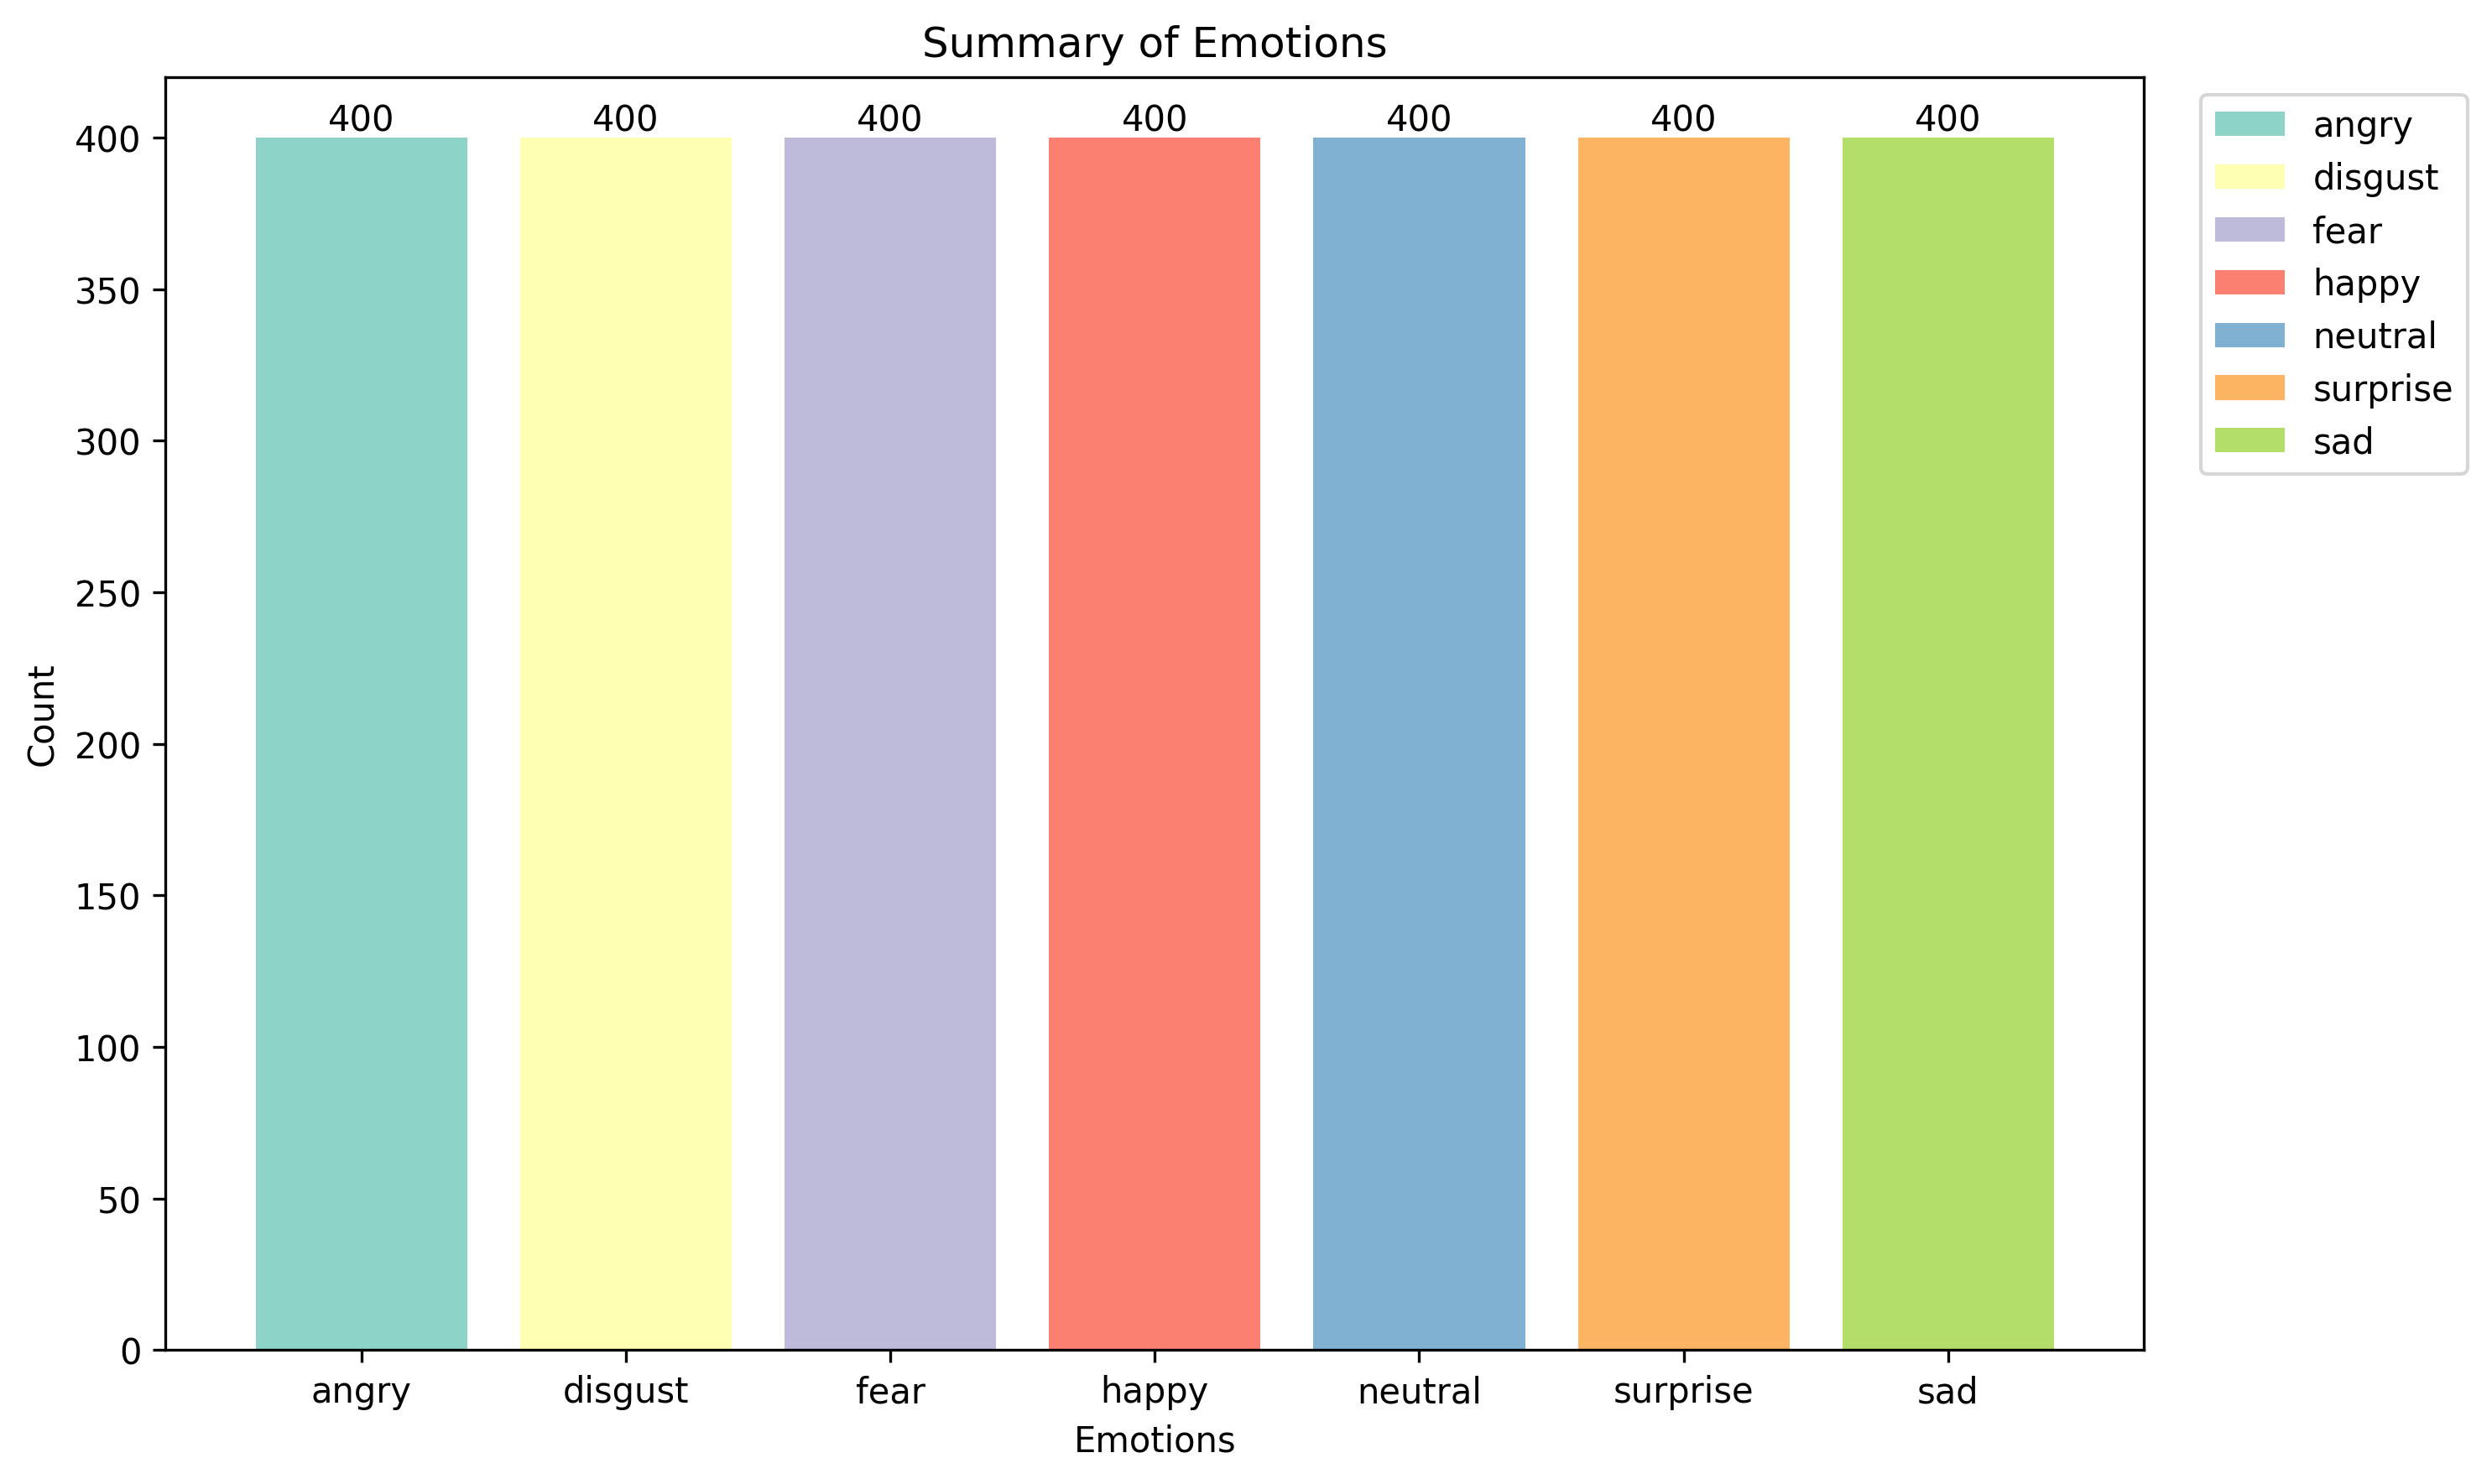

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# Compute emotion summary
emotion_summary = Tess_df['Emotions'].value_counts().reset_index()
emotion_summary.columns = ['Emotions', 'Count']

# Compute total
total = emotion_summary['Count'].sum()

# Add summation row to the emotion summary
emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)

# Display emotion summary as a table with total
table = tabulate(emotion_summary_with_total, headers='keys', tablefmt='fancy_grid')
print(table)

# Create high-resolution bar plot with color assignment and labels
plt.figure(figsize=(10, 6), dpi=300)
color_palette = plt.get_cmap('Set3')
bars = plt.bar(emotion_summary['Emotions'], emotion_summary['Count'], color=color_palette(np.arange(len(emotion_summary))))
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Summary of Emotions')

# Add labels to each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(emotion_summary['Count'][i]), ha='center', va='bottom')


# Move the legend to a better position
plt.legend(bars, emotion_summary['Emotions'], bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


4. CREMA-D dataset
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:



*   'a' = 'anger'
*   'd' = 'disgust'
*   'f' = 'fear'
*   'h' = 'happiness'
*   'n' = 'neutral'
*   'sa' = 'sadness'
*   'su' = 'surprise'


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
1    angry  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
2    angry  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
3    angry  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
4    angry  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...

<ipython-input-13-82747a8537d9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)


╒════╤════════════╤═════════╕
│    │ Emotions   │   Count │
╞════╪════════════╪═════════╡
│  0 │ neutral    │     120 │
├────┼────────────┼─────────┤
│  1 │ angry      │      60 │
├────┼────────────┼─────────┤
│  2 │ fear       │      60 │
├────┼────────────┼─────────┤
│  3 │ disgust    │      60 │
├────┼────────────┼─────────┤
│  4 │ happy      │      60 │
├────┼────────────┼─────────┤
│  5 │ surprise   │      60 │
├────┼────────────┼─────────┤
│  6 │ sad        │      60 │
├────┼────────────┼─────────┤
│  7 │ Total      │     480 │
╘════╧════════════╧═════════╛


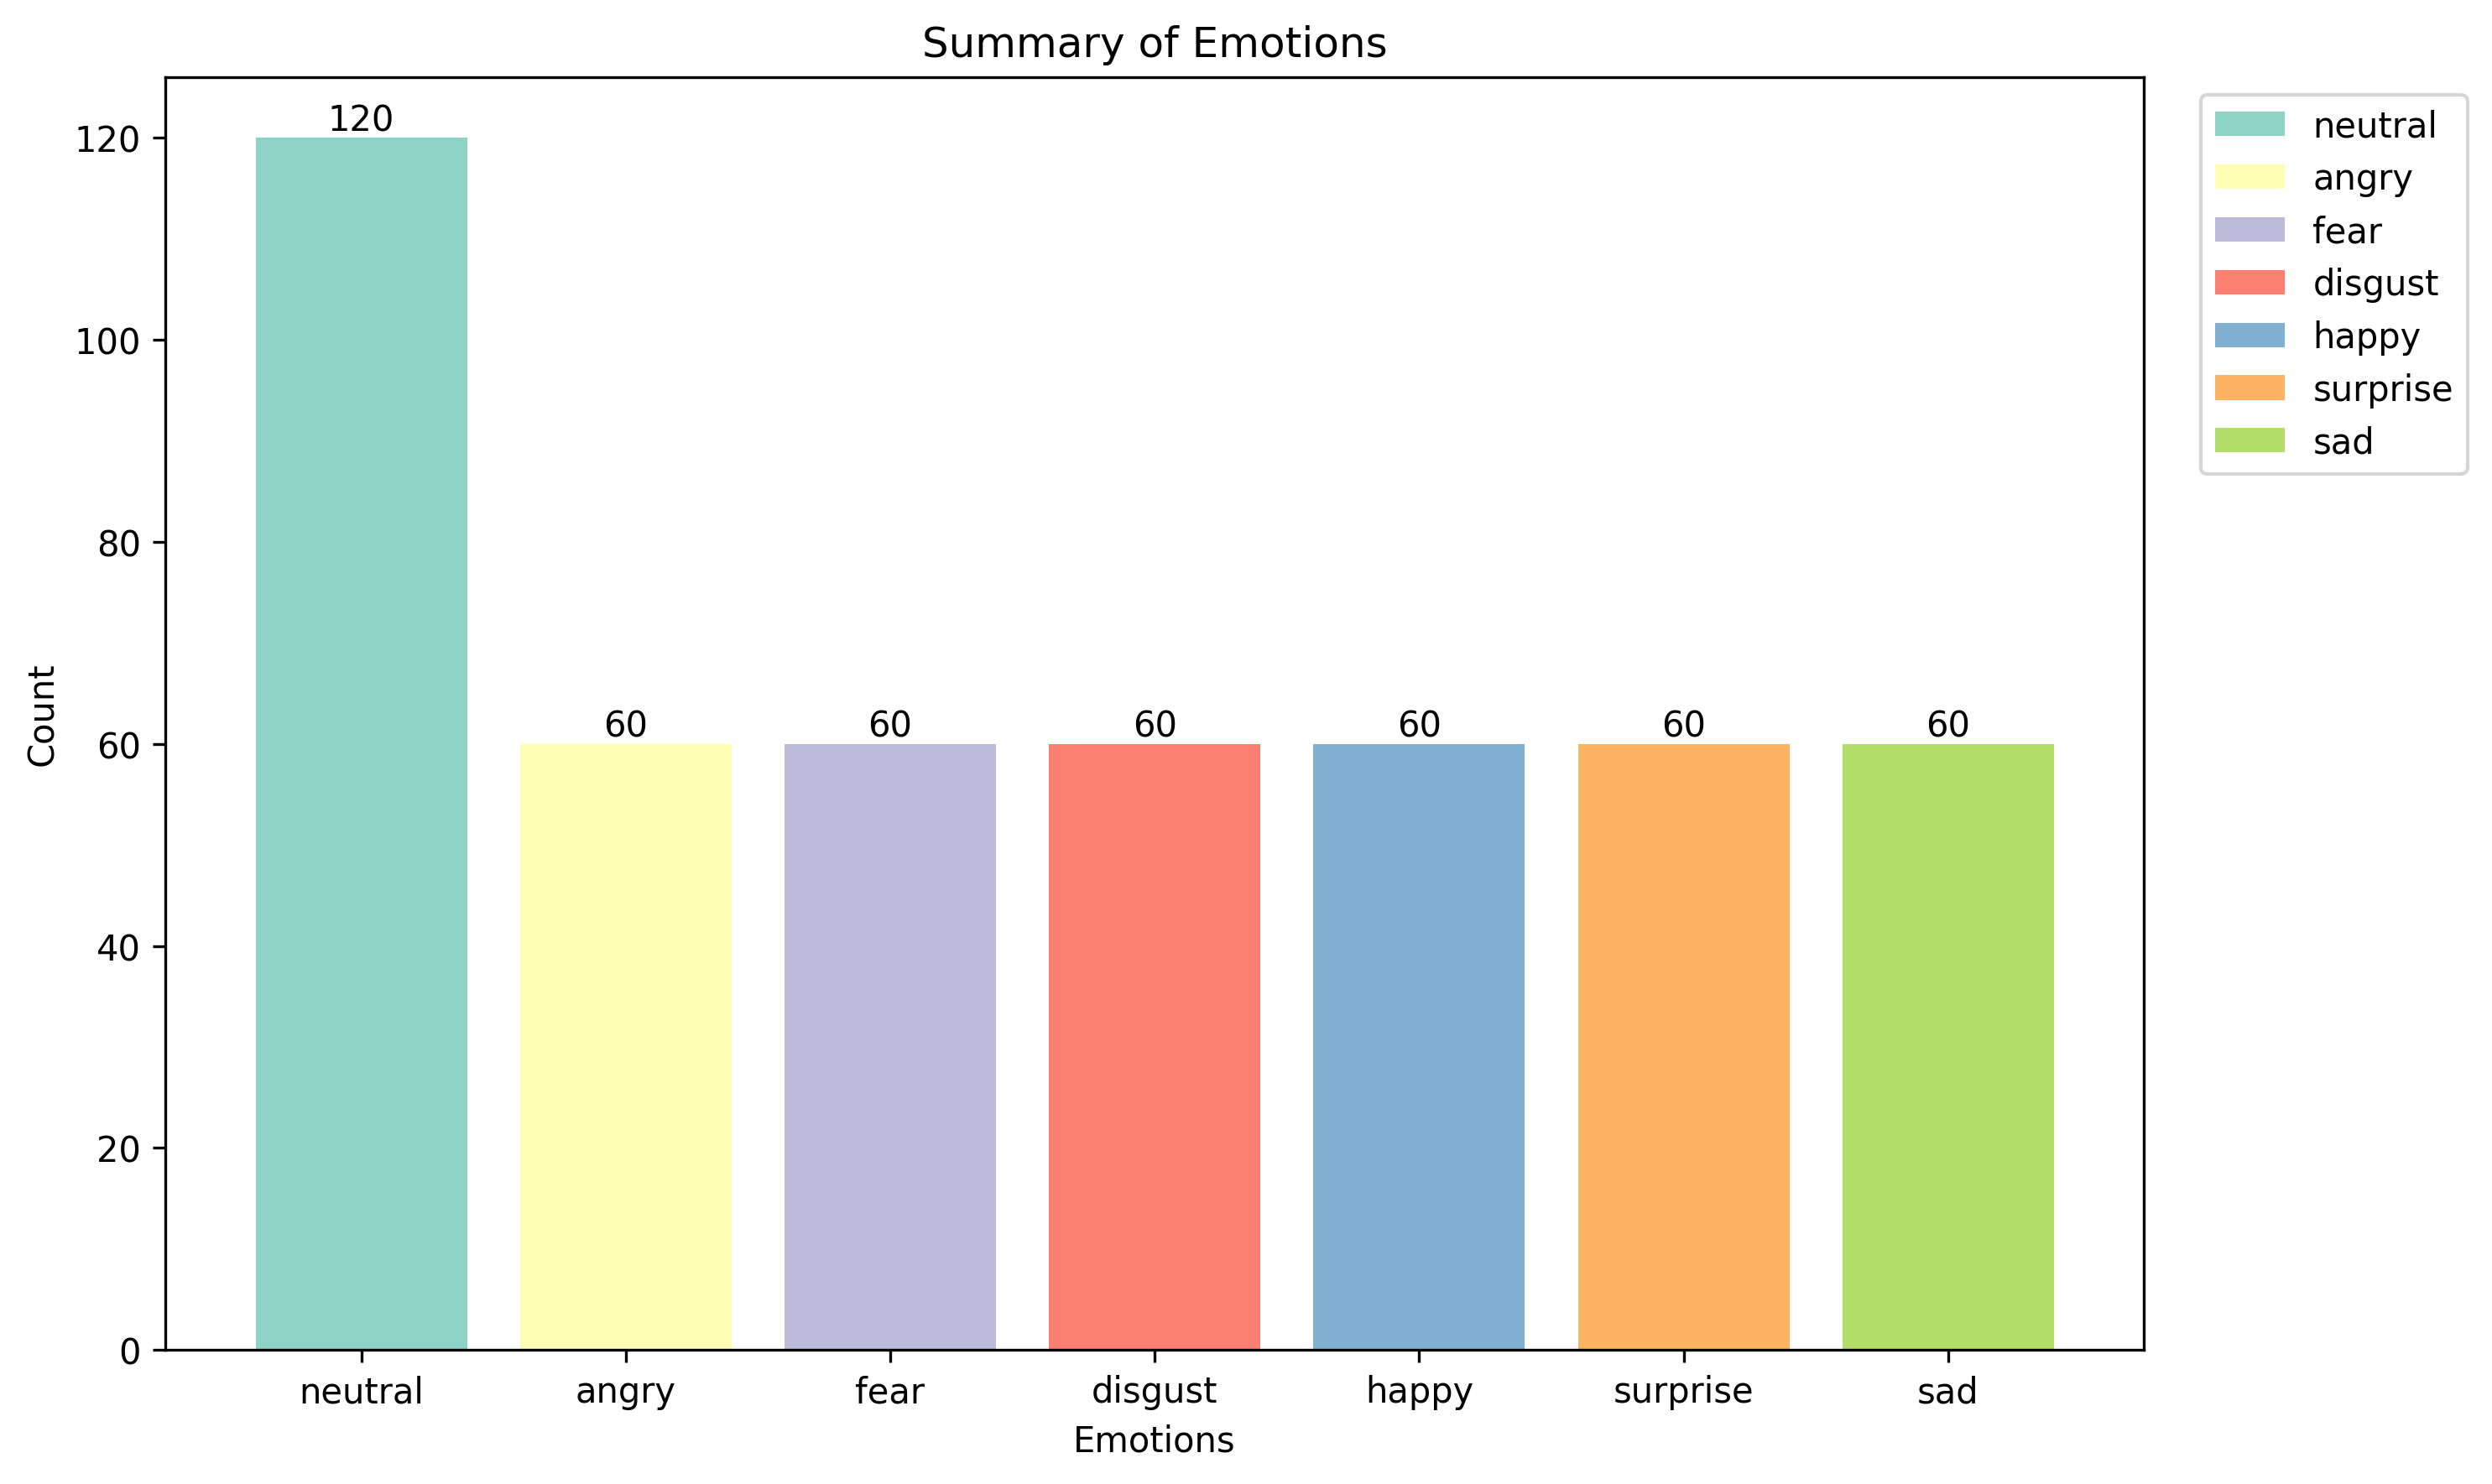

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# Compute emotion summary
emotion_summary = Savee_df['Emotions'].value_counts().reset_index()
emotion_summary.columns = ['Emotions', 'Count']

# Compute total
total = emotion_summary['Count'].sum()

# Add summation row to the emotion summary
emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)

# Display emotion summary as a table with total
table = tabulate(emotion_summary_with_total, headers='keys', tablefmt='fancy_grid')
print(table)

# Create high-resolution bar plot with color assignment and labels
plt.figure(figsize=(10, 6), dpi=300)
color_palette = plt.get_cmap('Set3')
bars = plt.bar(emotion_summary['Emotions'], emotion_summary['Count'], color=color_palette(np.arange(len(emotion_summary))))
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Summary of Emotions')

# Add labels to each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(emotion_summary['Count'][i]), ha='center', va='bottom')


# Move the legend to a better position
plt.legend(bars, emotion_summary['Emotions'], bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# We will compile a single dataframe by combining the four separate dataframes that we have created thus far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
# data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0      sad  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
1      sad  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
2    angry  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
3    angry  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
4     calm  /content/drive/MyDrive/Audio Analysis/RAVDESS/...

In [ ]:
data_path

Emotions                                               Path
0        sad  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
1        sad  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
2      angry  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
3      angry  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
4       calm  /content/drive/MyDrive/Audio Analysis/RAVDESS/...
..       ...                                                ...
475  neutral  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
476      sad  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
477  neutral  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
478  neutral  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...
479      sad  /content/drive/MyDrive/Audio Analysis/SAVEE/AL...

[12162 rows x 2 columns]

In [ ]:
# data_path=data_path.sample(frac=0.01)

In [ ]:
# data_path

# Exploratory Analysis

In [ ]:
data_path.Emotions

0          sad
1          sad
2        angry
3        angry
4         calm
        ...   
475    neutral
476        sad
477    neutral
478    neutral
479        sad
Name: Emotions, Length: 12162, dtype: object

To begin our analysis, we will create a visualization that displays the number of occurrences of each emotion in our dataset. This will help us explore and understand the distribution of emotions in our data.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute emotion summary
emotion_summary = data_path['Emotions'].value_counts().reset_index()
emotion_summary.columns = ['Emotions', 'Count']

# Compute total
total = emotion_summary['Count'].sum()

# Add summation row to the emotion summary
emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)

# Display emotion summary as a table with total
table = tabulate(emotion_summary_with_total, headers='keys', tablefmt='fancy_grid')
print(table)


╒════╤════════════╤═════════╕
│    │ Emotions   │   Count │
╞════╪════════════╪═════════╡
│  0 │ sad        │    1923 │
├────┼────────────┼─────────┤
│  1 │ angry      │    1923 │
├────┼────────────┼─────────┤
│  2 │ happy      │    1923 │
├────┼────────────┼─────────┤
│  3 │ disgust    │    1923 │
├────┼────────────┼─────────┤
│  4 │ fear       │    1923 │
├────┼────────────┼─────────┤
│  5 │ neutral    │    1703 │
├────┼────────────┼─────────┤
│  6 │ surprise   │     652 │
├────┼────────────┼─────────┤
│  7 │ calm       │     192 │
├────┼────────────┼─────────┤
│  8 │ Total      │   12162 │
╘════╧════════════╧═════════╛


<ipython-input-19-a1e17908303c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  emotion_summary_with_total = emotion_summary.append({'Emotions': 'Total', 'Count': total}, ignore_index=True)


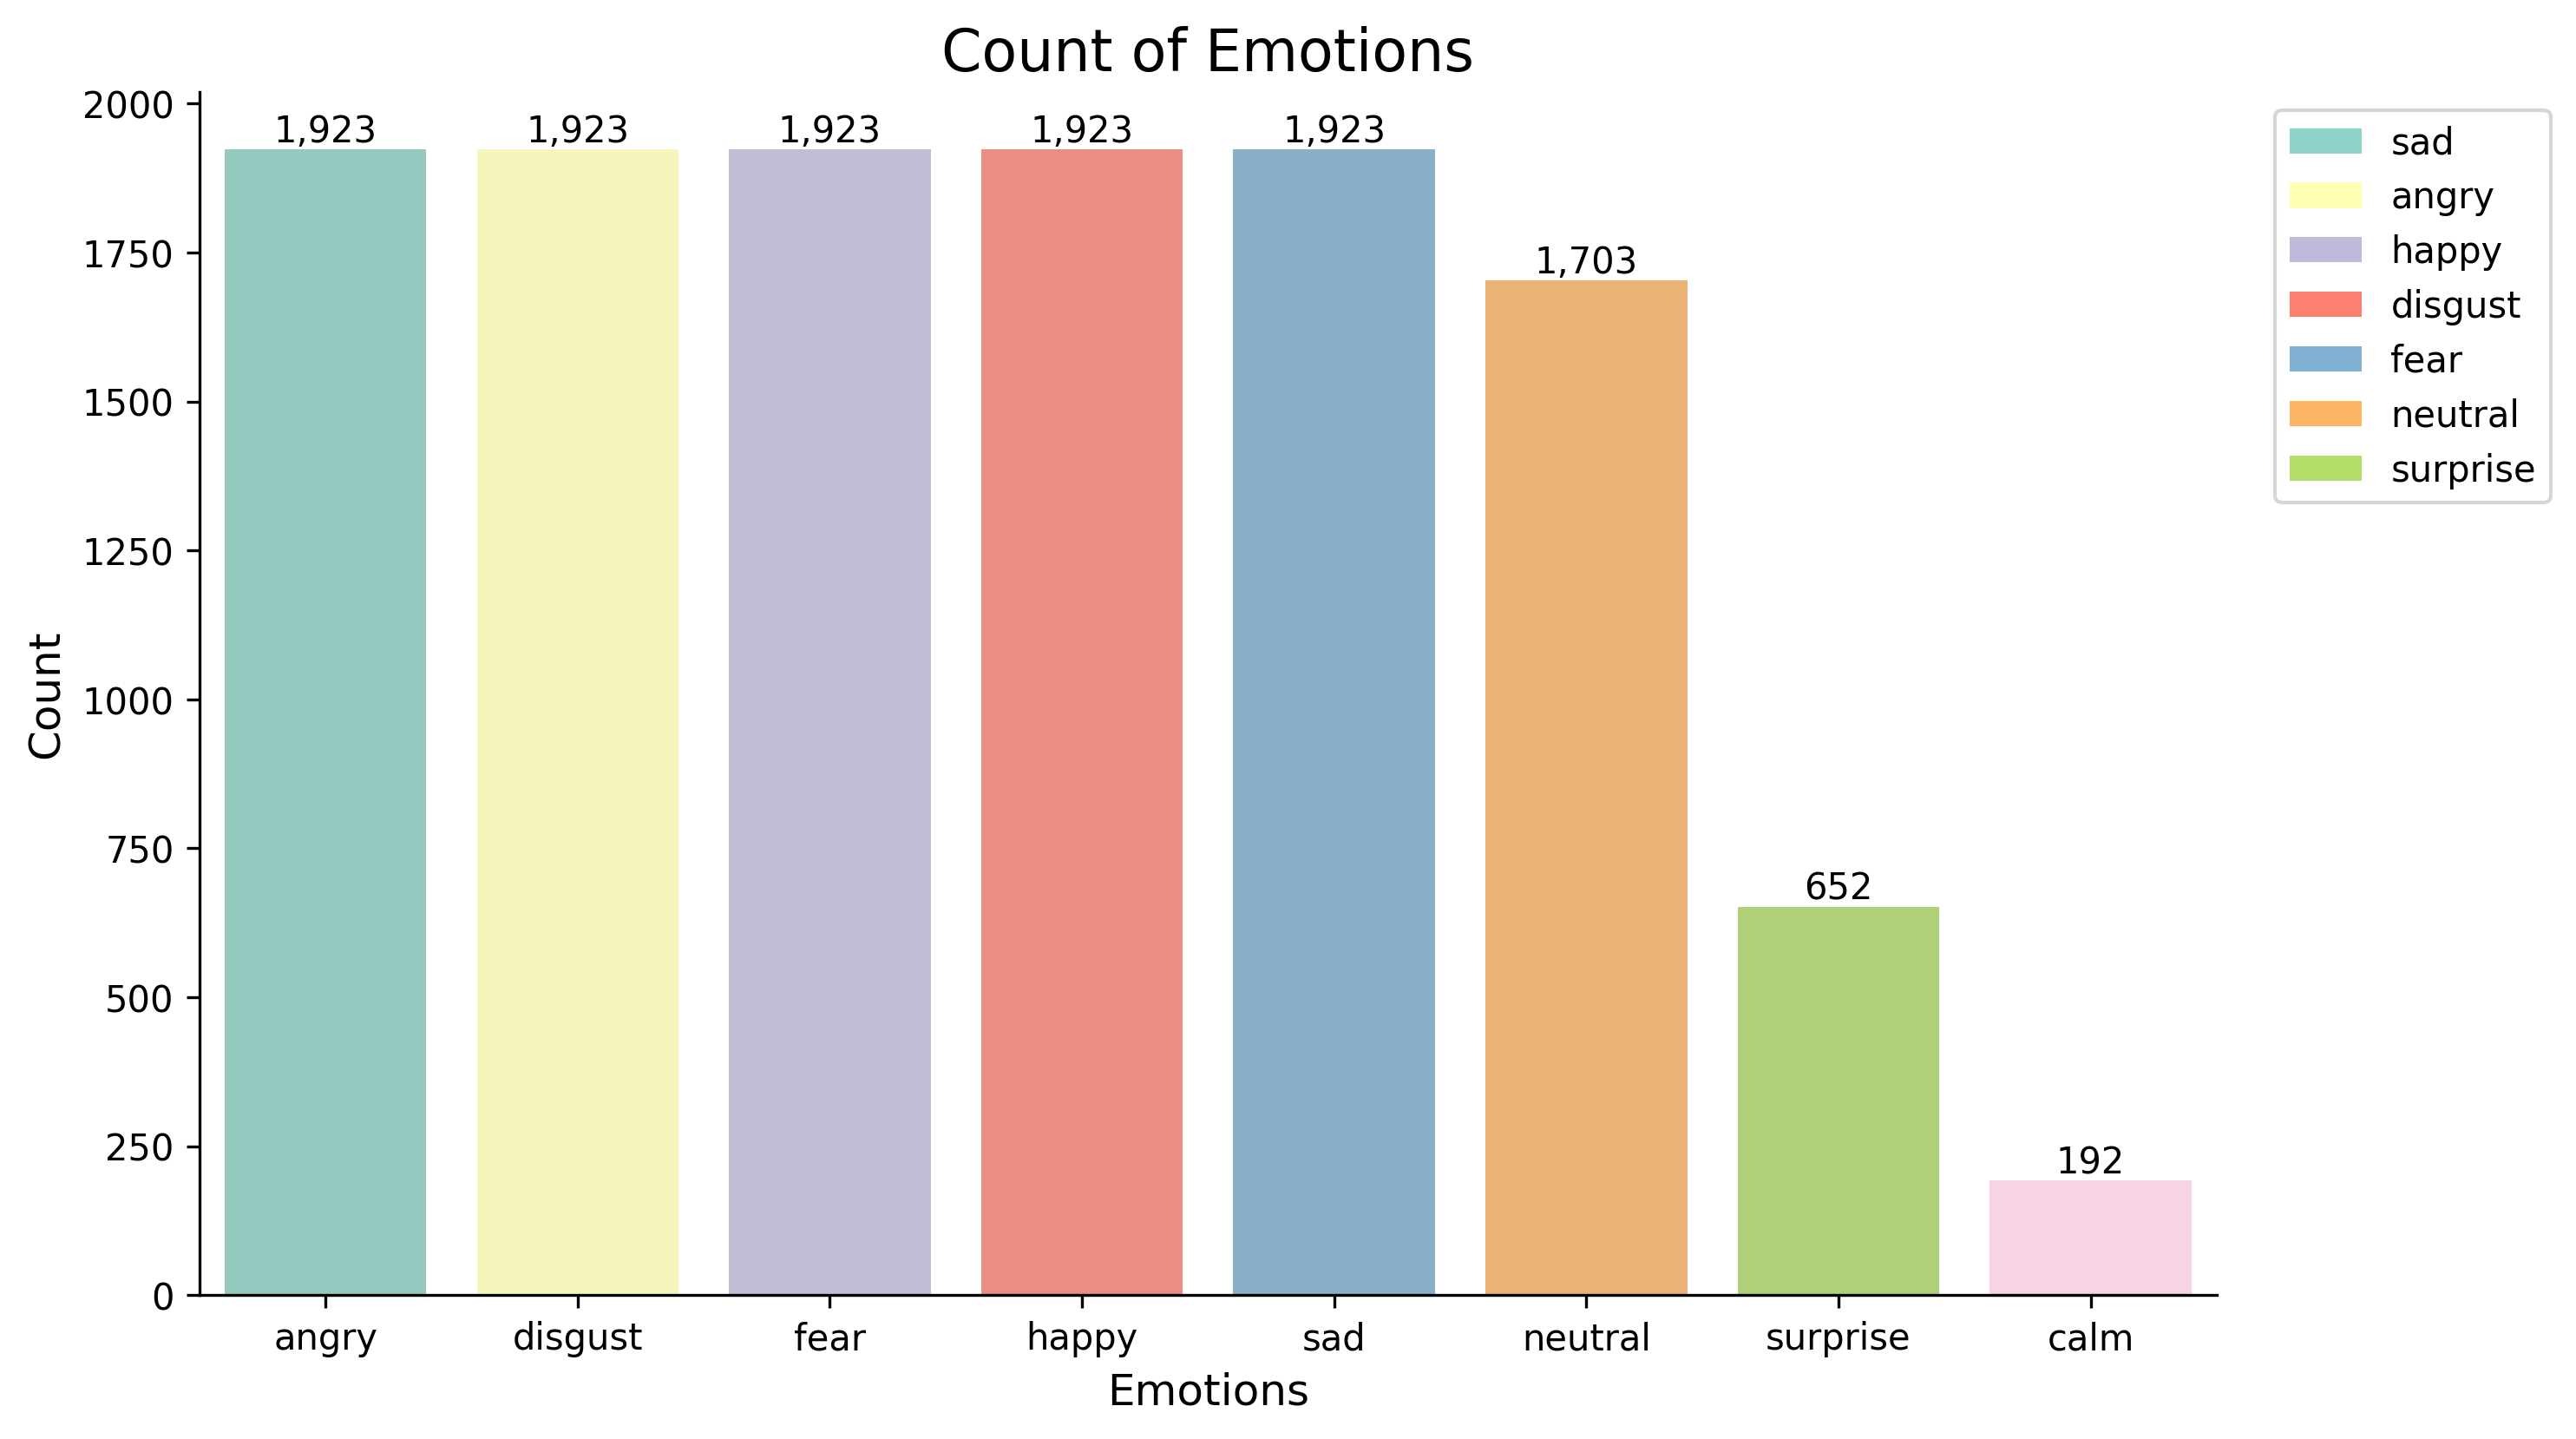

In [ ]:

# Sort the data by count in descending order
sorted_data = data_path.groupby('Emotions').size().sort_values(ascending=False)

# Set the figure size and resolution
plt.figure(figsize=(10, 6), dpi=300)

# Create countplot using seaborn with sorted data
sns.countplot(x='Emotions', data=data_path, order=sorted_data.index, palette='Set3')

# Add labels and title
plt.title('Count of Emotions', size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)

# Remove spines
sns.despine(top=True, right=True, left=False, bottom=False)

# Add labels to each bar
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Move the legend to a better position
plt.legend(bars, emotion_summary['Emotions'], bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()



We have the option to create visualizations of waveplots and spectrograms for audio signals. Waveplots provide information about the volume or loudness of the audio at a particular moment in time. Spectrograms, on the other hand, are graphical representations that show how the frequencies of sound or signals change over time. They illustrate the changes in frequencies over time for a given audio or music signal.

 Notice: waveplot needs to be changed to waveshow

In [ ]:
# def create_waveplot(data, sr, e):
#     plt.figure(figsize=(10, 3))
#     plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
#     librosa.display.waveshow(data, sr=sr)
#     plt.show()

# def create_spectrogram(data, sr, e):
#     # stft function converts the data into short term fourier transform
#     X = librosa.stft(data)
#     Xdb = librosa.amplitude_to_db(abs(X))
#     plt.figure(figsize=(12, 3))
#     plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
#     librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
#     #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
#     plt.colorbar()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    plt.plot(np.linspace(0, len(data) / sr, len(data)), data, color='b')
    plt.xlabel('Time (s)', size=12)
    plt.ylabel('Amplitude', size=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(np.abs(X))
    plt.figure(figsize=(12, 6))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', size=12)
    plt.ylabel('Frequency (Hz)', size=12)
    plt.tight_layout()
    plt.show()


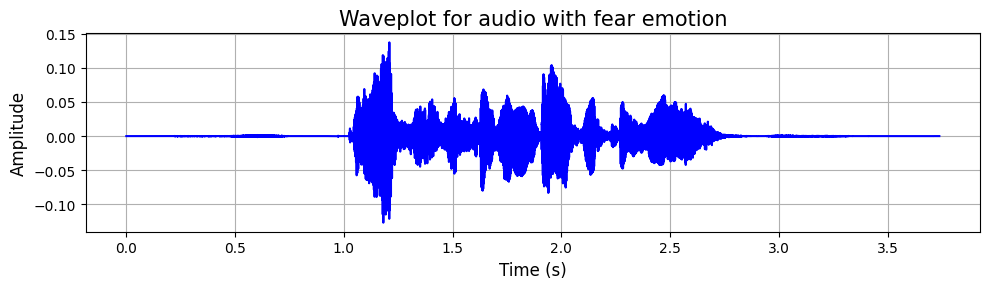

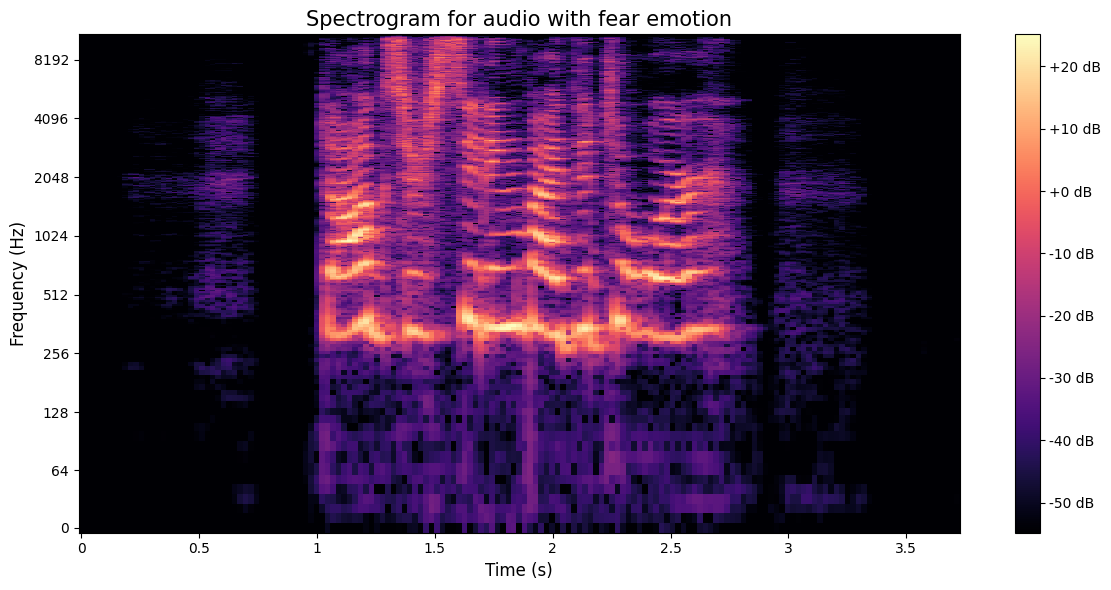

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

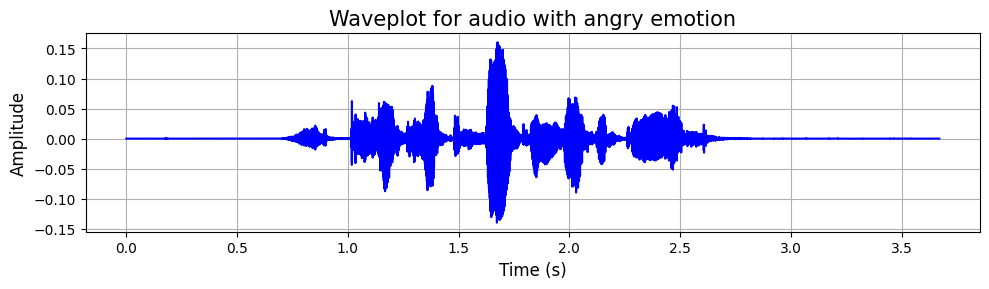

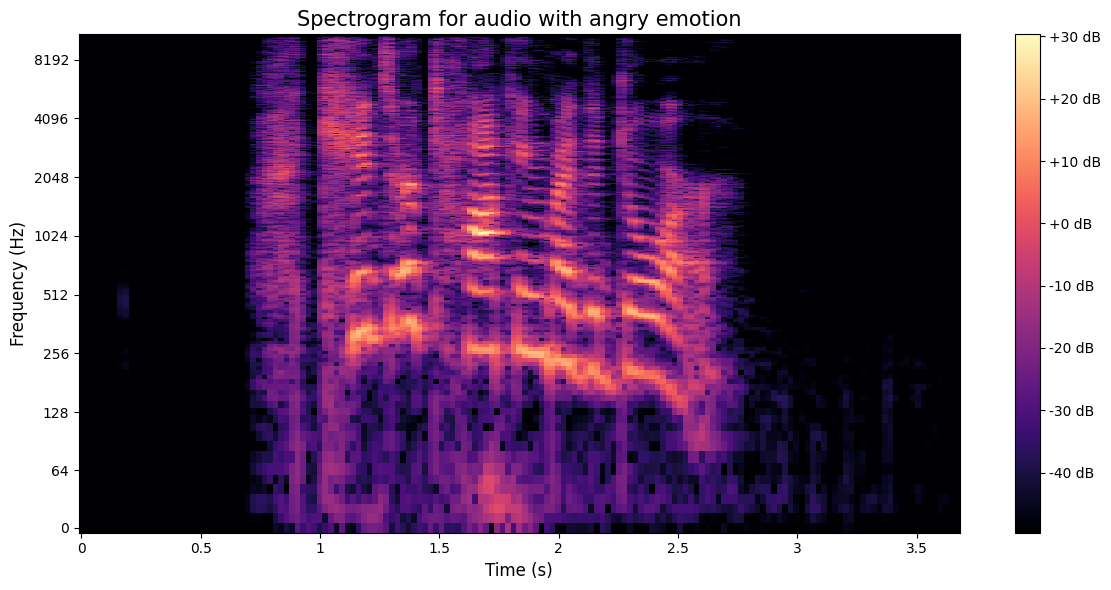

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

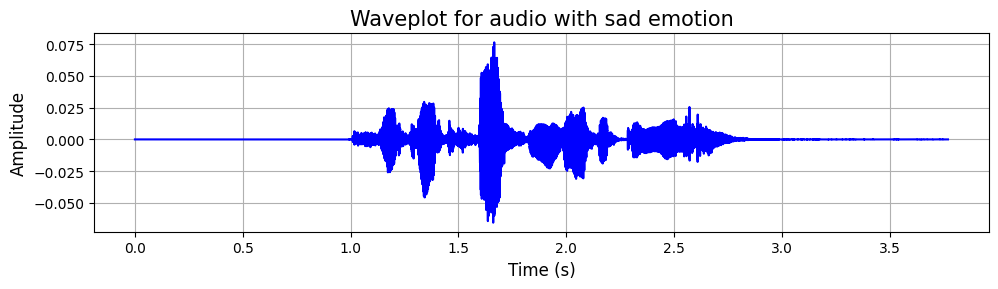

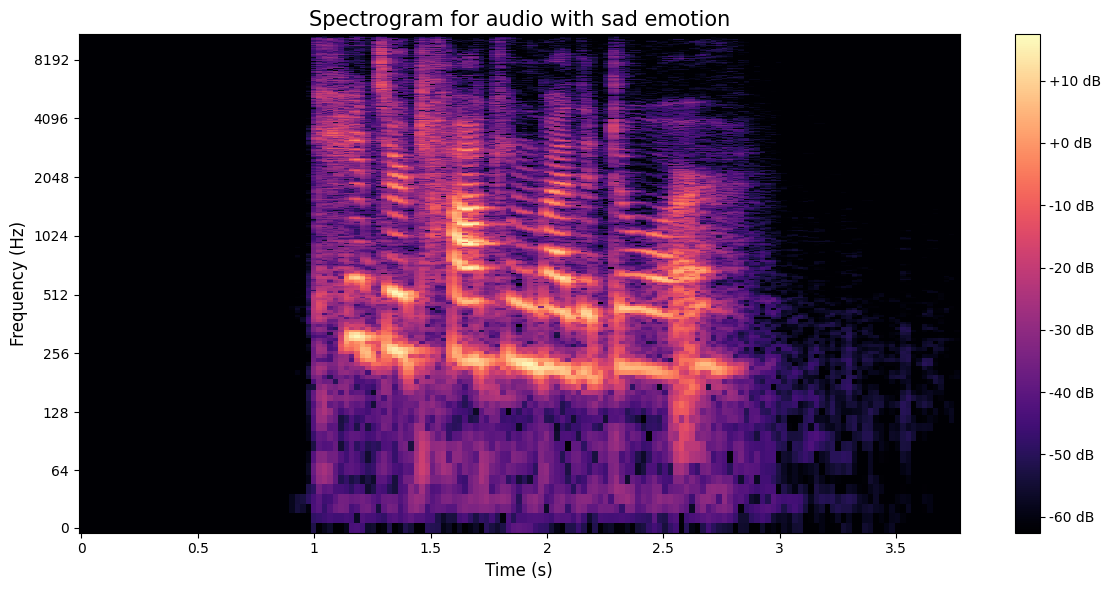

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

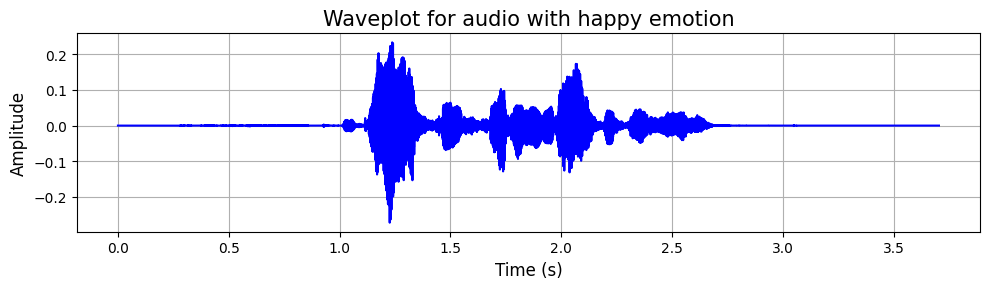

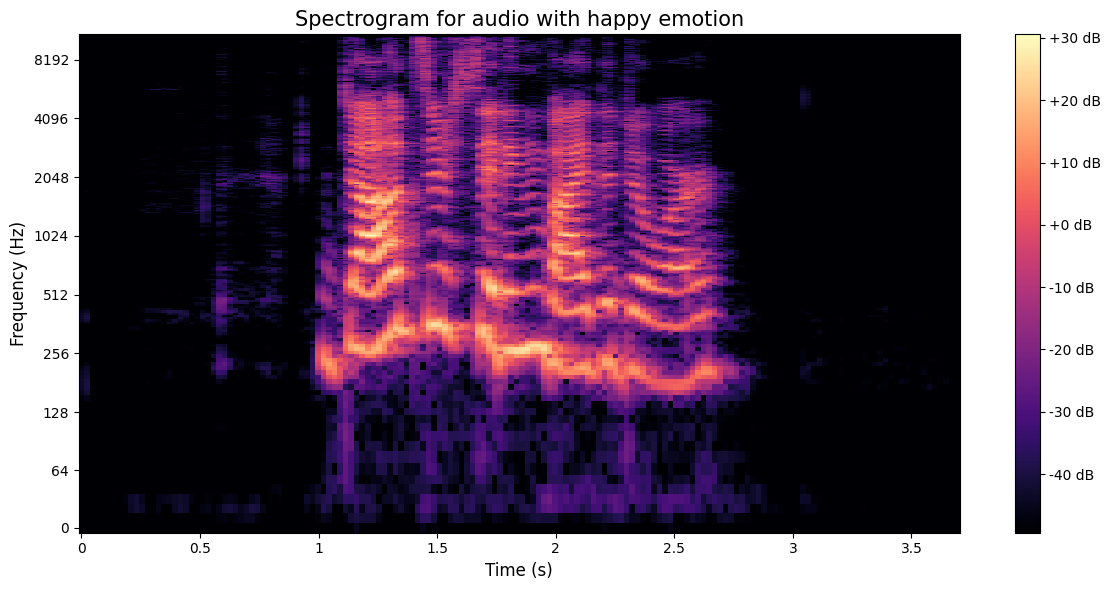

In [ ]:

emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation
Data augmentation is a method of generating additional data samples by introducing slight modifications to the original training set. For audio data, these modifications may include adding noise, altering pitch and speed, and shifting time. The purpose is to increase the robustness of our model to these perturbations and improve its generalization ability. It's important that these perturbations maintain the same label as the original sample to be effective. In image data, augmentation techniques may include rotating, zooming, or shifting the image. We will begin by evaluating which augmentation techniques are most effective for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.5)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data):
    return librosa.effects.pitch_shift(data, sr=0.5, n_steps=4)

#Other augmentation methods that  I am not going to use

# def time_masking(data, mask_value=0):
#     mask_start = int(np.random.uniform(low=0.1, high=0.5) * data.shape[0])
#     mask_end = int(np.random.uniform(low=0.5, high=0.9) * data.shape[0])
#     data[mask_start:mask_end] = mask_value
#     return data


# def frequency_masking(data, mask_value=0):
#     spectrogram = librosa.stft(data)
#     mask_start = int(np.random.uniform(low=0.1, high=0.5) * spectrogram.shape[0])
#     mask_end = int(np.random.uniform(low=0.5, high=0.9) * spectrogram.shape[0])
#     spectrogram[mask_start:mask_end, :] = mask_value
#     return librosa.istft(spectrogram)


# def dynamic_range_compression(data, threshold_db=-20, ratio=3):
#     data_amp = np.amax(data)
#     threshold = 10 ** (threshold_db / 20) * data_amp
#     compressed_data = np.where(np.abs(data) < threshold, data * ratio, data)
#     return compressed_data





# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

0. Simple Audio

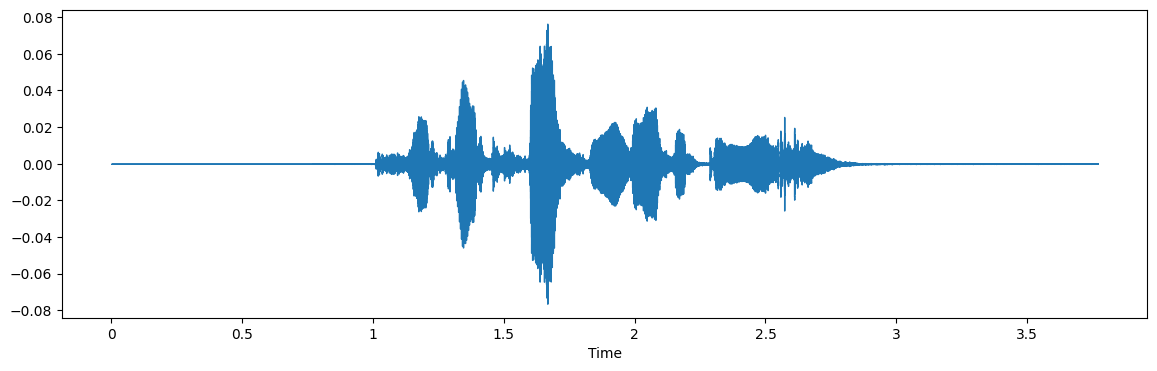

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

2. Noise Injection

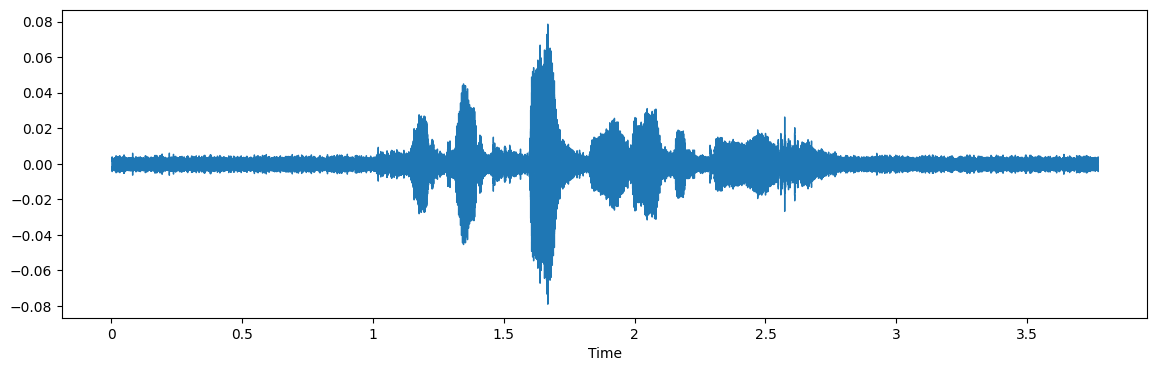

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Noise injection is a technique of adding a certain amount of random noise to an audio signal to create new and varied audio samples. By doing this, we can generate synthetic data that is similar to the original audio data, but with slight variations in terms of background noise. This helps in making the training model more robust and less prone to overfitting. When we add noise to audio, the model learns to identify important features in the audio signal despite the presence of noise. This helps to improve the generalization capability of the model and makes it more adaptable to new, unseen data. Therefore, noise injection is an effective data augmentation technique for audio datasets that can help in improving the performance of machine learning models.

3. Stretching (rate=0.5)

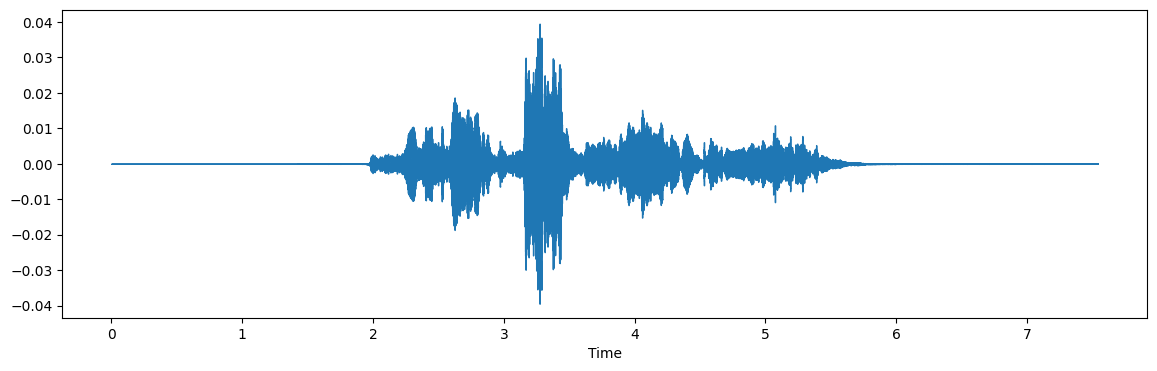

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

4. Shifting

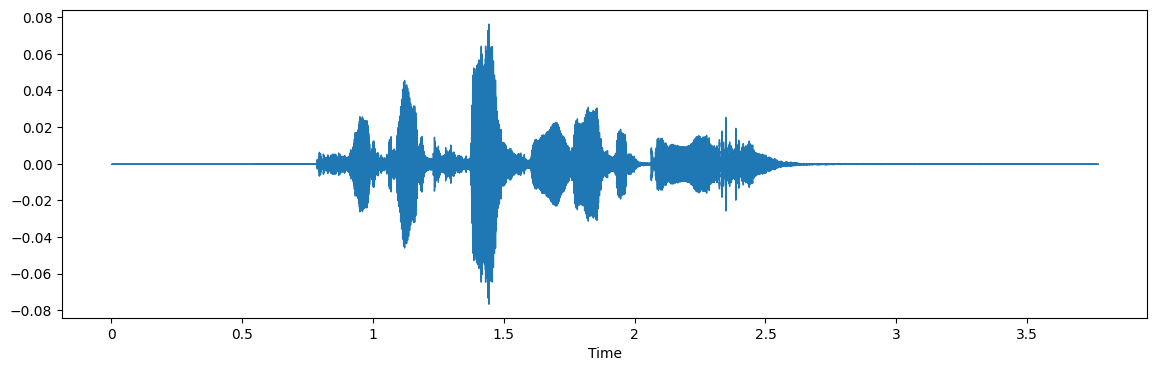

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

5. Pitch ( sr=0.5, n_steps=4)

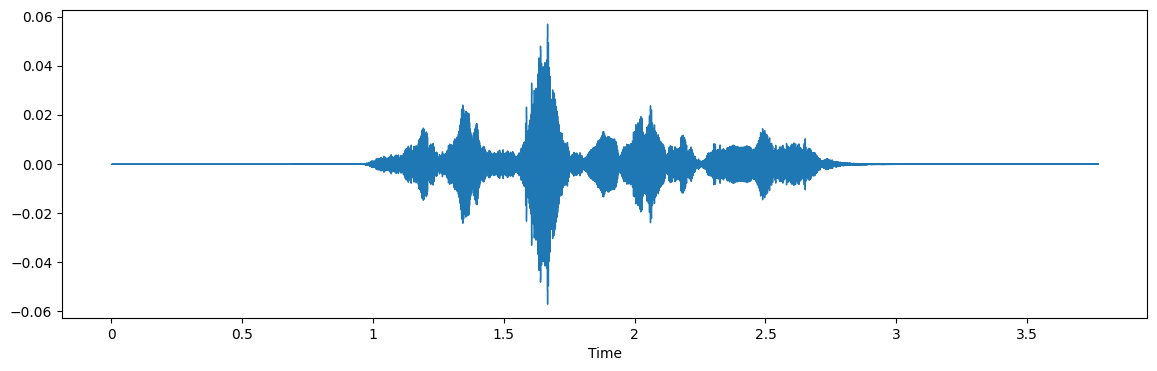

In [ ]:
x = pitch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

The augmentation techniques I am implementing for my data involve noise,stretching (i.e., changing speed), and pitching.

In [ ]:
import copy
original_data=data.copy()
original_data.shape

(83139,)

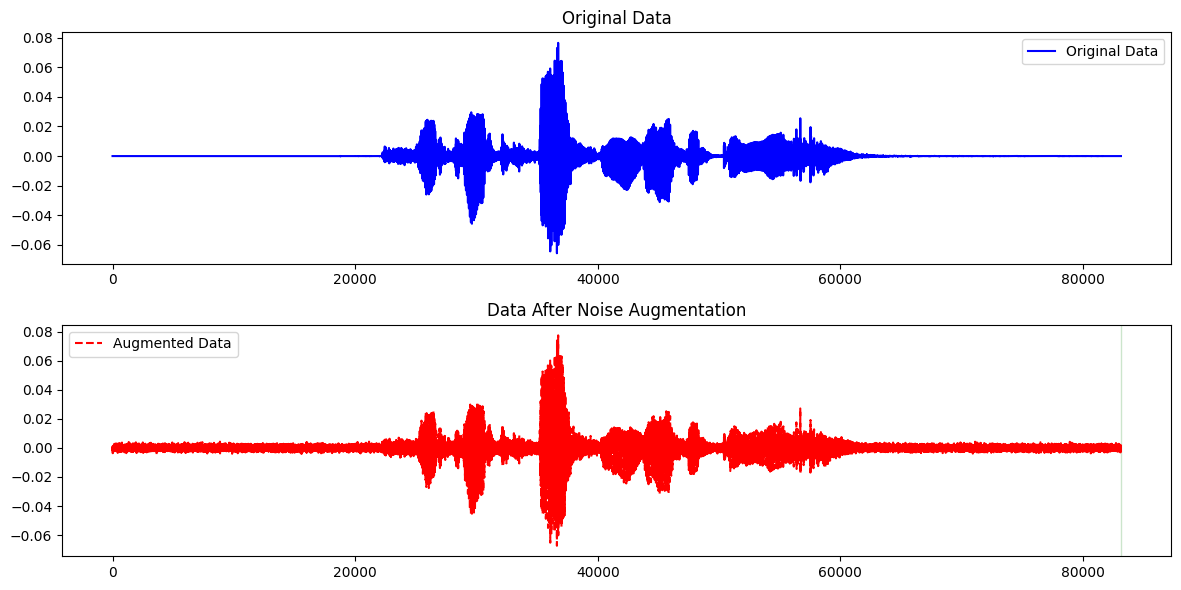

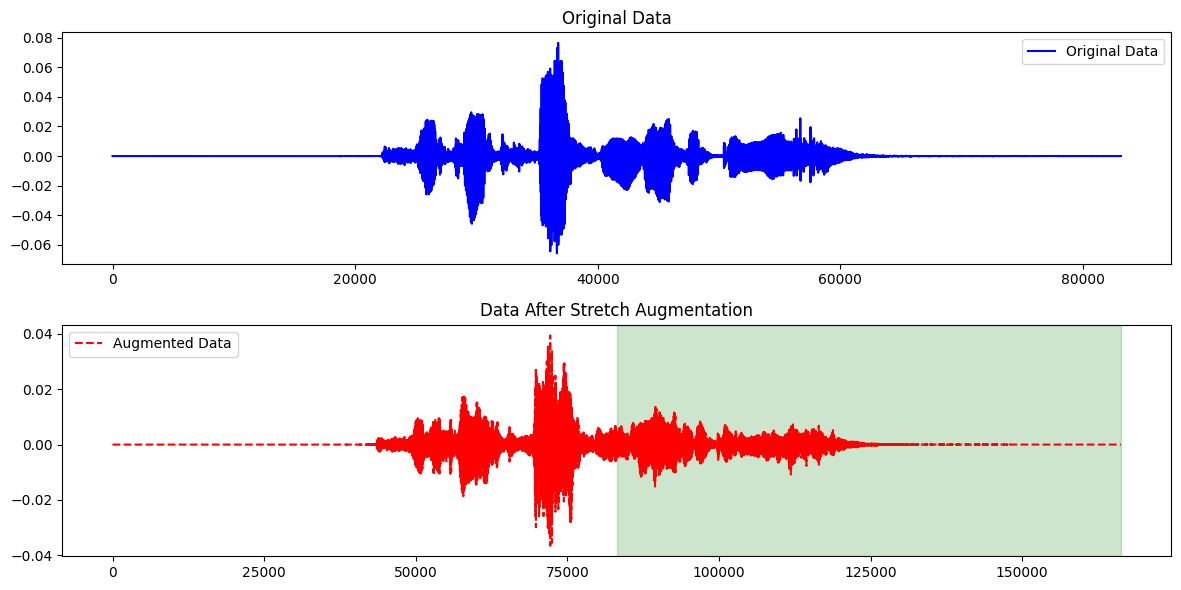

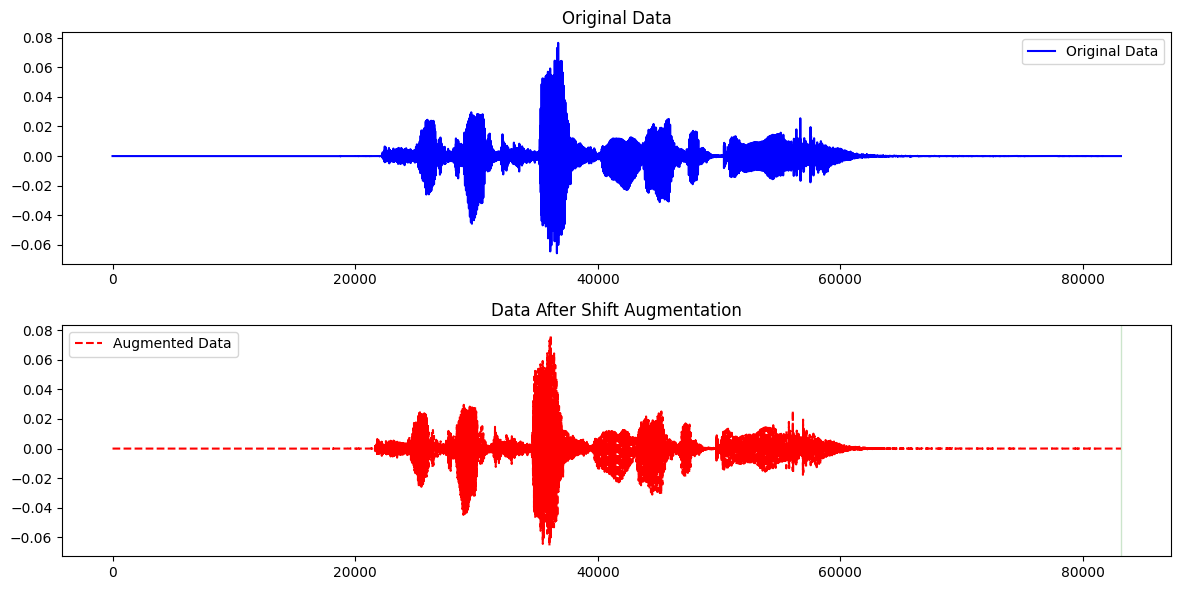

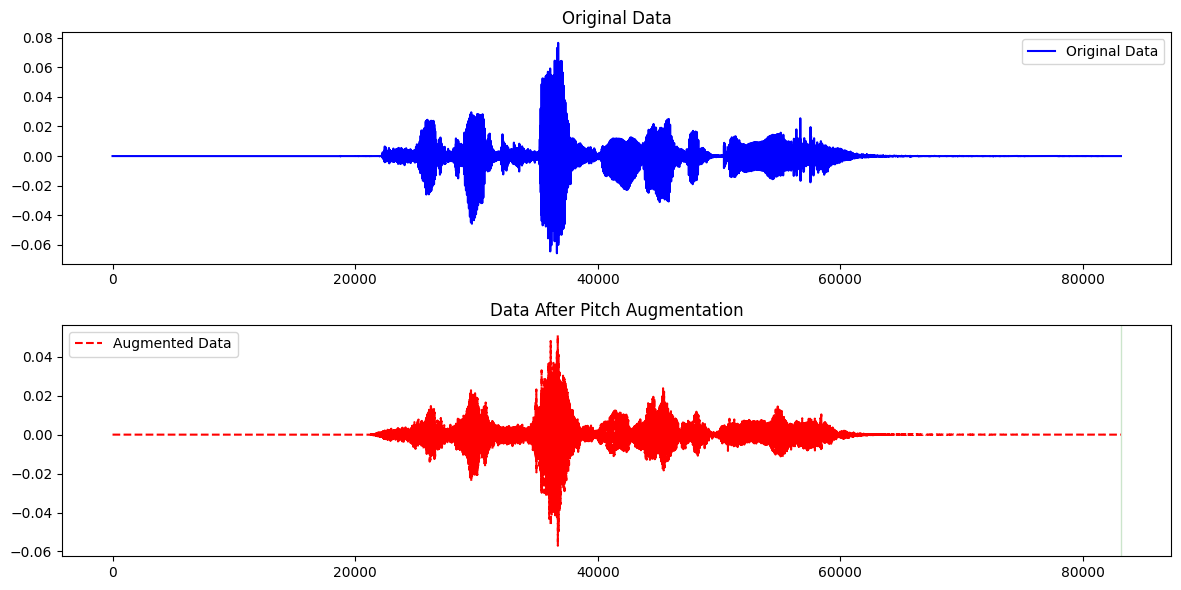

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def plot_data(data_before, data_after, title_before, title_after):
    plt.figure(figsize=(12, 6))

    # Plotting data before augmentation
    plt.subplot(2, 1, 1)
    plt.plot(data_before, color='b', linestyle='-', label='Original Data')
    plt.title(title_before)
    plt.legend()

    # Plotting data after augmentation
    plt.subplot(2, 1, 2)
    plt.plot(data_after, color='r', linestyle='--', label='Augmented Data')
    plt.title(title_after)
    plt.legend()

    # Highlighting changes
    change_start = min(len(data_before), len(data_after))
    change_end = max(len(data_before), len(data_after))
    plt.axvspan(change_start, change_end, color='g', alpha=0.2)

    plt.tight_layout()
    plt.show()

# Assuming you have some original data stored in a variable called 'original_data'

# Applying noise augmentation
augmented_data_noise = noise(original_data)
plot_data(original_data, augmented_data_noise, "Original Data", "Data After Noise Augmentation")

# Applying stretch augmentation
augmented_data_stretch = stretch(original_data)
plot_data(original_data, augmented_data_stretch, "Original Data", "Data After Stretch Augmentation")

# Applying shift augmentation
augmented_data_shift = shift(original_data)
plot_data(original_data, augmented_data_shift, "Original Data", "Data After Shift Augmentation")

# Applying pitch augmentation
augmented_data_pitch = pitch(original_data)
plot_data(original_data, augmented_data_pitch, "Original Data", "Data After Pitch Augmentation")


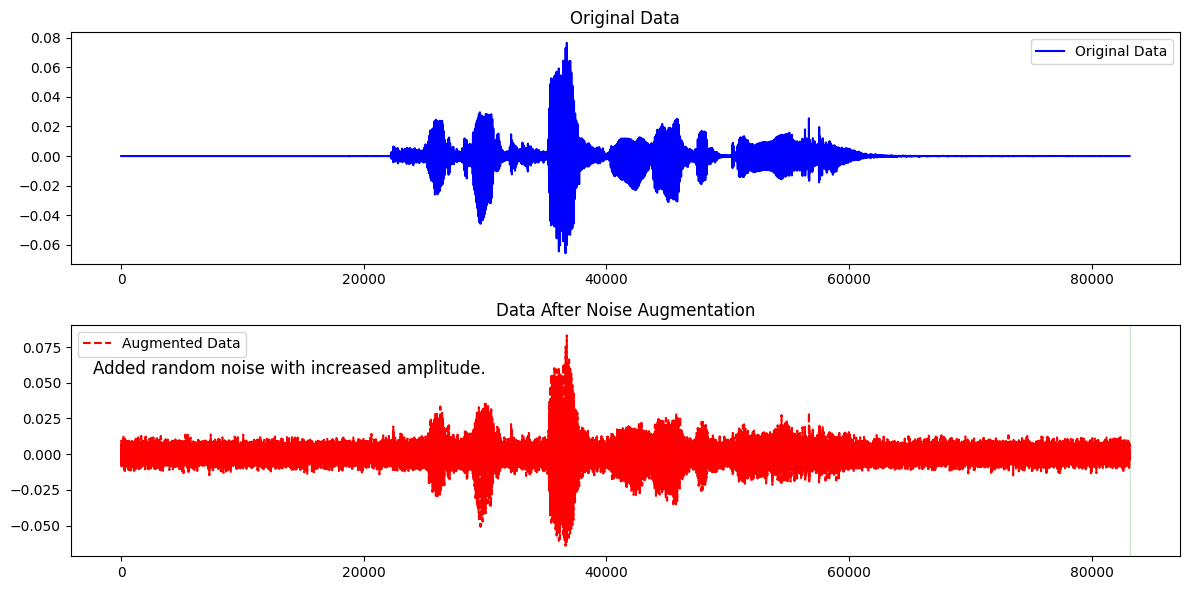

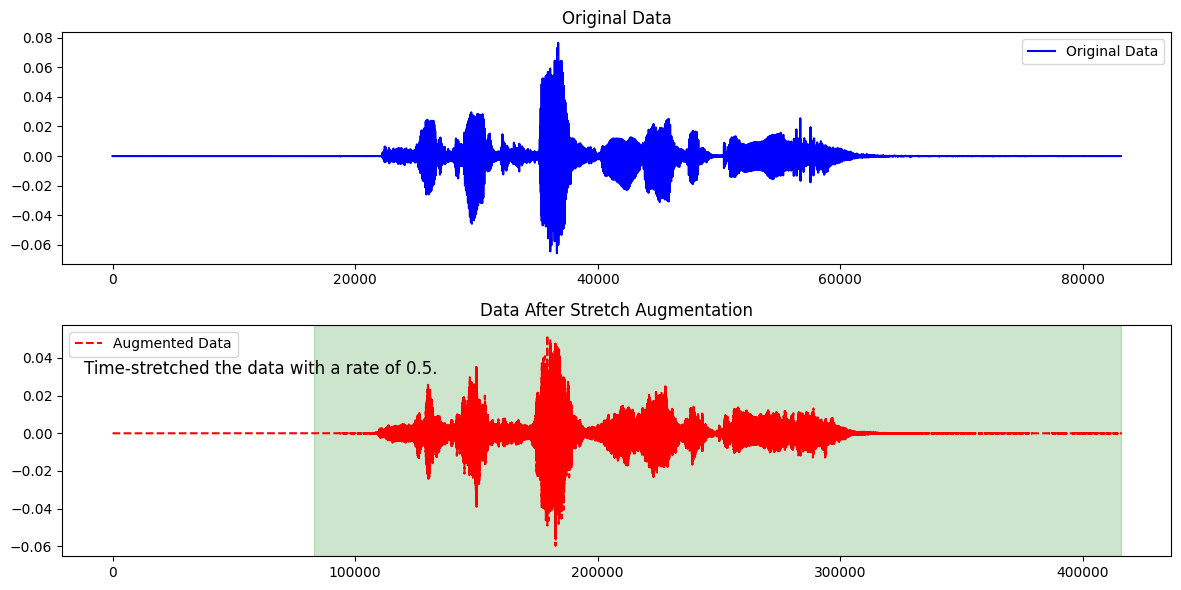

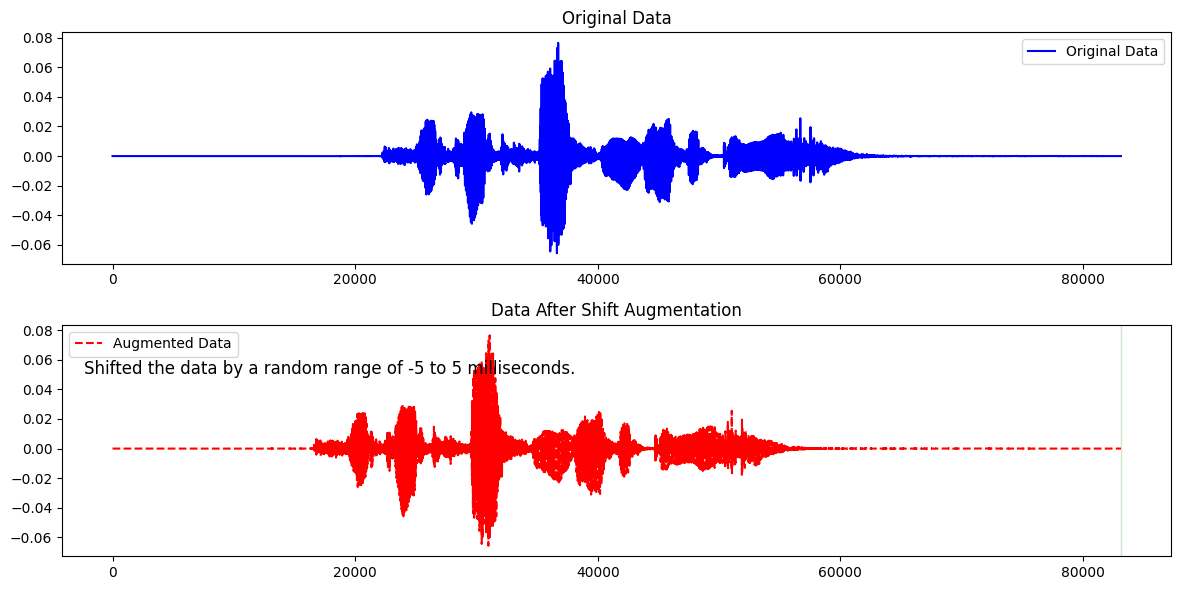

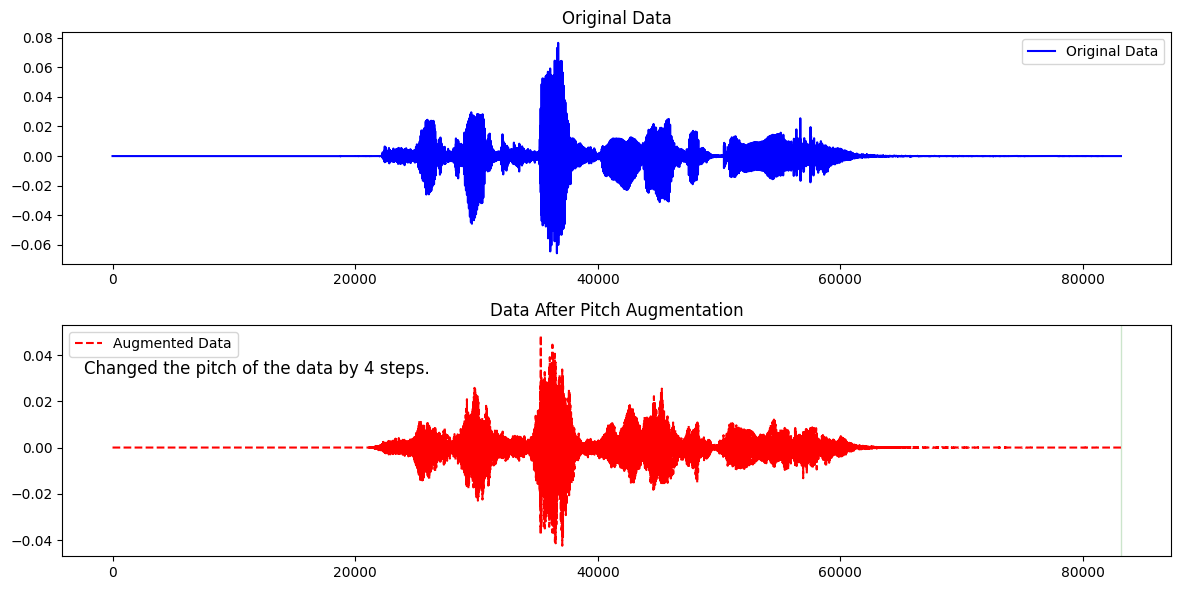

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def plot_data(data_before, data_after, title_before, title_after, changes):
    plt.figure(figsize=(12, 6))

    # Plotting data before augmentation
    plt.subplot(2, 1, 1)
    plt.plot(data_before, color='b', linestyle='-', label='Original Data')
    plt.title(title_before)
    plt.legend()

    # Plotting data after augmentation
    plt.subplot(2, 1, 2)
    plt.plot(data_after, color='r', linestyle='--', label='Augmented Data')
    plt.title(title_after)
    plt.legend()

    # Highlighting changes
    change_start = min(len(data_before), len(data_after))
    change_end = max(len(data_before), len(data_after))
    plt.axvspan(change_start, change_end, color='g', alpha=0.2)

    # Adding description of changes
    plt.text(0.02, 0.85, changes, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Assuming you have some original data stored in a variable called 'original_data'

# Applying noise augmentation
augmented_data_noise = noise(original_data)
changes_noise = "Added random noise with increased amplitude."
plot_data(original_data, augmented_data_noise, "Original Data", "Data After Noise Augmentation", changes_noise)

# Applying stretch augmentation
augmented_data_stretch = stretch(original_data)
changes_stretch = "Time-stretched the data with a rate of 0.5."
plot_data(original_data, augmented_data_stretch, "Original Data", "Data After Stretch Augmentation", changes_stretch)

# Applying shift augmentation
augmented_data_shift = shift(original_data)
changes_shift = "Shifted the data by a random range of -5 to 5 milliseconds."
plot_data(original_data, augmented_data_shift, "Original Data", "Data After Shift Augmentation", changes_shift)

# Applying pitch augmentation
augmented_data_pitch = pitch(original_data)
changes_pitch = "Changed the pitch of the data by 4 steps."
plot_data(original_data, augmented_data_pitch, "Original Data", "Data After Pitch Augmentation", changes_pitch)


It is just an FYI part to see what happens if we have implenet data augmentation with increased paramters to see changes more vividly :

In [ ]:
# import numpy as np
# import librosa
# import matplotlib.pyplot as plt

# def plot_data(data_before, data_after, title_before, title_after):
#     plt.figure(figsize=(12, 6))

#     # Plotting data before augmentation
#     plt.subplot(2, 1, 1)
#     plt.plot(data_before, color='b', linestyle='-', label='Original Data')
#     plt.title(title_before)
#     plt.legend()

#     # Plotting data after augmentation
#     plt.subplot(2, 1, 2)
#     plt.plot(data_after, color='r', linestyle='--', label='Augmented Data')
#     plt.title(title_after)
#     plt.legend()

#     # Highlighting changes
#     change_start = min(len(data_before), len(data_after))
#     change_end = max(len(data_before), len(data_after))
#     plt.axvspan(change_start, change_end, color='g', alpha=0.2)

#     plt.tight_layout()
#     plt.show()

# # Assuming you have some original data stored in a variable called 'original_data'

# # Applying noise augmentation with increased noise amplitude
# def noise(data):
#     noise_amp = 0.1 * np.random.uniform() * np.amax(data)  # Increased noise amplitude
#     data = data + noise_amp * np.random.normal(size=data.shape[0])
#     return data

# augmented_data_noise = noise(original_data)
# plot_data(original_data, augmented_data_noise, "Original Data", "Data After Noise Augmentation")

# # Applying stretch augmentation with increased time stretching rate
# def stretch(data):
#     return librosa.effects.time_stretch(data, rate=0.2)  # Increased time stretching rate

# augmented_data_stretch = stretch(original_data)
# plot_data(original_data, augmented_data_stretch, "Original Data", "Data After Stretch Augmentation")

# # Applying shift augmentation with increased shift range
# def shift(data):
#     shift_range = int(np.random.uniform(low=-10, high=10) * 1000)  # Increased shift range
#     return np.roll(data, shift_range)

# augmented_data_shift = shift(original_data)
# plot_data(original_data, augmented_data_shift, "Original Data", "Data After Shift Augmentation")

# # Applying pitch augmentation with increased pitch shifting steps
# def pitch(data):
#     return librosa.effects.pitch_shift(data, sr=0.5, n_steps=8)  # Increased pitch shifting steps

# augmented_data_pitch = pitch(original_data)
# plot_data(original_data, augmented_data_pitch, "Original Data", "Data After Pitch Augmentation")


# Feature Extraction


Feature extraction is a crucial step in analyzing and identifying relationships among different components. As audio data is not directly interpretable by models, it needs to be transformed into a comprehensible format, and that's where feature extraction comes into play. The audio signal is a three-dimensional signal with time, amplitude, and frequency as its axes.

The features I have chosen for my Emotion Classification project, including Zero Crossing Rate, Chroma_stft, MFCC, RMS (root mean square) value, and MelSpectogram, have been selected based on their ability to capture relevant information related to emotional content in audio signals.

In emotion classification, it is crucial to identify acoustic characteristics and patterns in audio signals that convey different emotional states. Through empirical observations and previous research in the field of emotion recognition and audio signal processing, these features have emerged as effective indicators of emotions in audio data.

The Zero Crossing Rate feature measures the rate at which the audio signal crosses the zero axis and is associated with changes in the signal's amplitude and frequency. Chroma_stft captures the distribution of pitch classes in the audio signal, providing insights into tonal content and harmonic characteristics. MFCCs (Mel-frequency cepstral coefficients) represent the spectral features of the audio signal and are sensitive to variations in timbre and texture. RMS calculates the root mean square value of the signal, reflecting its overall amplitude and energy. Lastly, MelSpectogram provides a visual representation of the power distribution across different frequencies over time, highlighting the spectral content of the audio.

The choice of these features is based on both empirical observations and prior research, which have consistently demonstrated their effectiveness in capturing emotional information in audio signals. Researchers have conducted studies using machine learning techniques to classify emotions based on acoustic features, and these features have shown promising results in discriminating emotional states accurately.

While there is a wealth of research on emotion recognition and audio signal processing, these features have been widely used and acknowledged for their relevance in the field of Emotion Classification. By analyzing and leveraging these features, I aim to develop a robust model that can accurately classify emotions in audio data, contributing to our understanding of emotional content in audio signals and potentially enabling applications in fields such as human-computer interaction, affective computing, and audio-based sentiment analysis.


*   Zero Crossing Rate
*   Chroma_stft
*   MFCC
*   RMS (root mean square) value
*   MelSpectogram to train our model

There are also other features one can use. I have commented them below so if you want you can use them :

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    # # Spectral Centroid
    # centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, centroid)) # stacking horizontally

    # # Spectral Bandwidth
    # bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, bandwidth)) # stacking horizontally

    # # Spectral Contrast
    # contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, contrast)) # stacking horizontally

    # # Tonnetz
    # tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, tonnetz)) # stacking horizontally

    # # Additional Statistical Features
    # var = np.var(data)
    # skewness = np.skew(data)
    # kurtosis = np.kurtosis(data)
    # result = np.hstack((result, var, skewness, kurtosis)) # stacking horizontally

    return result



# def get_features(path):
#     # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#     data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

#     # without augmentation
#     res1 = extract_features(data)
#     result = np.array(res1)

#     # data with noise
#     noise_data = noise(data)
#     res2 = extract_features(noise_data)
#     result = np.vstack((result, res2)) # stacking vertically

#     # data with stretching and pitching
#     new_data = stretch(data)
#     data_stretch_pitch = pitch(new_data)
#     res3 = extract_features(data_stretch_pitch)
#     result = np.vstack((result, res3)) # stacking vertically

#     return result

In [ ]:
def get_features(path):
    # Load audio data with specified duration and offset to handle any silence at the start or end
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features from the original audio data
    features_original = extract_features(data)

    # Data augmentation: Add noise to the audio
    data_with_noise = noise(data)
    features_noise = extract_features(data_with_noise)

    # Data augmentation: Stretch and pitch shift the audio
    stretched_data = stretch(data)
    pitched_data = pitch(stretched_data)
    features_stretch_pitch = extract_features(pitched_data)

    # Data augmentation: Shift the audio
    shifted_data = shift(data)
    features_shift = extract_features(shifted_data)

    # Combine all feature sets vertically
    result = np.vstack((features_original, features_noise, features_stretch_pitch, features_shift))

    return result


In [ ]:
X, Y = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions),total=len(data_path)):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


In [ ]:
len(X), len(Y), data_path.Path.shape

(200, 200, (50,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.221711  0.717623  0.676820  0.622114  0.567222  0.530047  0.506060   
1  0.306333  0.808334  0.809195  0.735504  0.693425  0.694983  0.614841   
2  0.200202  0.618428  0.558264  0.555919  0.587506  0.678541  0.643793   
3  0.180614  0.484732  0.403829  0.449593  0.510690  0.473447  0.472625   
4  0.257428  0.611021  0.566790  0.617001  0.670517  0.640898  0.588802   

          7         8         9  ...       153       154       155       156  \
0  0.513090  0.538911  0.587742  ...  0.000163  0.000123  0.000252  0.000208   
1  0.595060  0.609359  0.654337  ...  0.000274  0.000229  0.000363  0.000318   
2  0.560025  0.519437  0.523522  ...  0.000035  0.000018  0.000012  0.000012   
3  0.470697  0.535387  0.645654  ...  0.000020  0.000043  0.000020  0.000011   
4  0.554699  0.604893  0.697609  ...  0.000071  0.000090  0.000070  0.000057   

        157       158       159       160           161  labels  
0  0.000273  0.000186  0.000112  0.000028  1.877223e-06     sad  
1  0.000388  0.000294  0.000226  0.000141  1.102960e-04     sad  
2  0.000010  0.000013  0.000012  0.000010  7.289458e-07     sad  
3  0.000007  0.000011  0.000006  0.000002  2.938744e-07     sad  
4  0.000058  0.000061  0.000057  0.000051  5.109764e-05     sad  

[5 rows x 163 columns]

In [ ]:
Features=pd.read_csv('features.csv')
Features

0         1         2         3         4         5         6  \
0      0.221711  0.717623  0.676820  0.622114  0.567222  0.530047  0.506060   
1      0.306333  0.808334  0.809195  0.735504  0.693425  0.694983  0.614841   
2      0.200202  0.618428  0.558264  0.555919  0.587506  0.678541  0.643793   
3      0.180614  0.484732  0.403829  0.449593  0.510690  0.473447  0.472625   
4      0.257428  0.611021  0.566790  0.617001  0.670517  0.640898  0.588802   
...         ...       ...       ...       ...       ...       ...       ...   
36481  0.030332  0.628117  0.624942  0.596301  0.480619  0.466382  0.528422   
36482  0.036598  0.509419  0.505649  0.609432  0.552910  0.542113  0.531851   
36483  0.019934  0.604011  0.543243  0.477521  0.442807  0.412928  0.421630   
36484  0.041838  0.698420  0.660117  0.618702  0.593643  0.575627  0.562585   
36485  0.019807  0.485216  0.421145  0.460388  0.541552  0.553963  0.503138   

              7         8         9  ...           153           154  \
0      0.513090  0.538911  0.587742  ...  1.625823e-04  1.227060e-04   
1      0.595060  0.609359  0.654337  ...  2.740127e-04  2.288649e-04   
2      0.560025  0.519437  0.523522  ...  3.534336e-05  1.786805e-05   
3      0.470697  0.535387  0.645654  ...  2.042610e-05  4.280592e-05   
4      0.554699  0.604893  0.697609  ...  7.113000e-05  9.004290e-05   
...         ...       ...       ...  ...           ...           ...   
36481  0.565323  0.576542  0.573873  ...  8.153068e-07  8.291537e-07   
36482  0.522220  0.445416  0.355434  ...  6.088640e-07  5.016910e-07   
36483  0.510570  0.592495  0.525786  ...  5.620556e-08  4.005692e-08   
36484  0.607697  0.662594  0.600693  ...  2.987277e-05  2.945807e-05   
36485  0.424389  0.405417  0.389682  ...  1.487685e-06  8.131670e-07   

                155           156           157           158           159  \
0      2.520911e-04  2.082695e-04  2.732483e-04  1.859348e-04  1.117308e-04   
1      3.629544e-04  3.177298e-04  3.879392e-04  2.939013e-04  2.258861e-04   
2      1.174114e-05  1.182243e-05  9.551801e-06  1.264313e-05  1.228576e-05   
3      1.985392e-05  1.054747e-05  6.596223e-06  1.057199e-05  5.627526e-06   
4      7.025031e-05  5.700416e-05  5.787766e-05  6.094981e-05  5.690050e-05   
...             ...           ...           ...           ...           ...   
36481  8.351180e-07  7.875340e-07  7.679594e-07  8.005923e-07  8.275033e-07   
36482  3.516936e-07  1.094733e-07  8.996469e-08  3.546998e-08  1.273642e-08   
36483  3.565935e-08  3.383525e-08  3.466478e-08  3.474812e-08  3.548512e-08   
36484  2.930258e-05  2.751308e-05  2.882735e-05  2.960830e-05  3.025193e-05   
36485  6.066540e-07  5.595791e-07  4.733269e-07  1.201343e-07  7.414812e-08   

                160           161   labels  
0      2.795662e-05  1.877223e-06      sad  
1      1.410695e-04  1.102960e-04      sad  
2      1.044788e-05  7.289458e-07      sad  
3      2.074922e-06  2.938744e-07      sad  
4      5.095462e-05  5.109764e-05      sad  
...             ...           ...      ...  
36481  8.177092e-07  8.067297e-07  neutral  
36482  6.050051e-09  3.158192e-10  neutral  
36483  3.250027e-08  2.158683e-08      sad  
36484  2.905682e-05  2.885426e-05      sad  
36485  2.692369e-08  2.336392e-09      sad  

[36486 rows x 163 columns]

Data augmentation has been implemented and features have been extracted for each audio file and then saved.

# Data Preparation

In [ ]:
Features=pd.read_csv('features.csv')
Features

0         1         2         3         4         5         6  \
0      0.221711  0.717623  0.676820  0.622114  0.567222  0.530047  0.506060   
1      0.306333  0.808334  0.809195  0.735504  0.693425  0.694983  0.614841   
2      0.200202  0.618428  0.558264  0.555919  0.587506  0.678541  0.643793   
3      0.180614  0.484732  0.403829  0.449593  0.510690  0.473447  0.472625   
4      0.257428  0.611021  0.566790  0.617001  0.670517  0.640898  0.588802   
...         ...       ...       ...       ...       ...       ...       ...   
36481  0.030332  0.628117  0.624942  0.596301  0.480619  0.466382  0.528422   
36482  0.036598  0.509419  0.505649  0.609432  0.552910  0.542113  0.531851   
36483  0.019934  0.604011  0.543243  0.477521  0.442807  0.412928  0.421630   
36484  0.041838  0.698420  0.660117  0.618702  0.593643  0.575627  0.562585   
36485  0.019807  0.485216  0.421145  0.460388  0.541552  0.553963  0.503138   

              7         8         9  ...           153           154  \
0      0.513090  0.538911  0.587742  ...  1.625823e-04  1.227060e-04   
1      0.595060  0.609359  0.654337  ...  2.740127e-04  2.288649e-04   
2      0.560025  0.519437  0.523522  ...  3.534336e-05  1.786805e-05   
3      0.470697  0.535387  0.645654  ...  2.042610e-05  4.280592e-05   
4      0.554699  0.604893  0.697609  ...  7.113000e-05  9.004290e-05   
...         ...       ...       ...  ...           ...           ...   
36481  0.565323  0.576542  0.573873  ...  8.153068e-07  8.291537e-07   
36482  0.522220  0.445416  0.355434  ...  6.088640e-07  5.016910e-07   
36483  0.510570  0.592495  0.525786  ...  5.620556e-08  4.005692e-08   
36484  0.607697  0.662594  0.600693  ...  2.987277e-05  2.945807e-05   
36485  0.424389  0.405417  0.389682  ...  1.487685e-06  8.131670e-07   

                155           156           157           158           159  \
0      2.520911e-04  2.082695e-04  2.732483e-04  1.859348e-04  1.117308e-04   
1      3.629544e-04  3.177298e-04  3.879392e-04  2.939013e-04  2.258861e-04   
2      1.174114e-05  1.182243e-05  9.551801e-06  1.264313e-05  1.228576e-05   
3      1.985392e-05  1.054747e-05  6.596223e-06  1.057199e-05  5.627526e-06   
4      7.025031e-05  5.700416e-05  5.787766e-05  6.094981e-05  5.690050e-05   
...             ...           ...           ...           ...           ...   
36481  8.351180e-07  7.875340e-07  7.679594e-07  8.005923e-07  8.275033e-07   
36482  3.516936e-07  1.094733e-07  8.996469e-08  3.546998e-08  1.273642e-08   
36483  3.565935e-08  3.383525e-08  3.466478e-08  3.474812e-08  3.548512e-08   
36484  2.930258e-05  2.751308e-05  2.882735e-05  2.960830e-05  3.025193e-05   
36485  6.066540e-07  5.595791e-07  4.733269e-07  1.201343e-07  7.414812e-08   

                160           161   labels  
0      2.795662e-05  1.877223e-06      sad  
1      1.410695e-04  1.102960e-04      sad  
2      1.044788e-05  7.289458e-07      sad  
3      2.074922e-06  2.938744e-07      sad  
4      5.095462e-05  5.109764e-05      sad  
...             ...           ...      ...  
36481  8.177092e-07  8.067297e-07  neutral  
36482  6.050051e-09  3.158192e-10  neutral  
36483  3.250027e-08  2.158683e-08      sad  
36484  2.905682e-05  2.885426e-05      sad  
36485  2.692369e-08  2.336392e-09      sad  

[36486 rows x 163 columns]

The next steps involve normalizing and splitting the data into training and testing sets.

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

# Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
# Define a function to create the model
def create_model(dropout_rate=0.2, units=32, kernel_size=5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(256, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(128, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(64, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=8, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143860 sha256=dbacd4654c200c8c7fd3c1cf9fd252ed5626b9fc278efead1e88a58aea64c9ad
  Stored in directory: /root/.cache/pip/wheels

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Set the experiment name in MLflow
mlflow.set_experiment("Hyperparameter Tuning")

# Create a KerasClassifier wrapper for use with scikit-learn
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters to tune
param_grid = {
    'epochs': [1, 5],  # Number of training epochs
    'batch_size': [64],  # Batch size
    'learning_rate': [0.01, 0.1]  # Learning rate
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

with mlflow.start_run():
    # Perform the grid search with tqdm progress bar
    with tqdm(total=len(param_grid)) as pbar:
        grid_result = grid.fit(x_train, y_train, verbose=1)
        pbar.update()

    # Log the best parameters and score
    mlflow.log_params(grid_result.best_params_)
    mlflow.log_metric("best_score", grid_result.best_score_)


  0%|          | 0/3 [00:00<?, ?it/s]

143/143 [==============================] - 1s 5ms/step - loss: 1.9634 - accuracy: 0.1548
Epoch 1/5
286/286 [==============================] - 3s 10ms/step - loss: 1.9068 - accuracy: 0.2682
Epoch 2/5
286/286 [==============================] - 3s 10ms/step - loss: 1.6850 - accuracy: 0.3135
Epoch 3/5
286/286 [==============================] - 3s 9ms/step - loss: 1.6582 - accuracy: 0.3292
Epoch 4/5
286/286 [==============================] - 3s 9ms/step - loss: 1.6273 - accuracy: 0.3366
Epoch 5/5
143/143 [==============================] - 1s 4ms/step - loss: 1.5732 - accuracy: 0.3603
Epoch 1/5
286/286 [==============================] - 3s 10ms/step - loss: 1.8241 - accuracy: 0.2637
Epoch 2/5
286/286 [==============================] - 3s 9ms/step - loss: 1.7433 - accuracy: 0.2905
Epoch 3/5
286/286 [==============================] - 3s 9ms/step - loss: 1.7113 - accuracy: 0.2907
Epoch 4/5
286/286 [==============================] - 3s 9ms/step - loss: 1.6571 - accuracy: 0.3141
Epoch 5/5
143/143

 33%|███▎      | 1/3 [03:19<06:39, 199.81s/it]


In [ ]:
# Create a KerasClassifier wrapper for use with scikit-learn
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters to tune
param_grid = {
    'epochs': [1, 5],  # Number of training epochs
    'batch_size': [32],  # Batch size
    'units': [16],  # Number of units in dense layers
    'kernel_size': [3 ],  # Kernel size
    'dropout_rate': [0.2],  # Dropout rate
    'learning_rate': [0.1],  # Learning rate
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Perform the grid search with tqdm progress bar
with tqdm(total=len(param_grid)) as pbar:
    grid_result = grid.fit(x_train, y_train, verbose=0)
    pbar.update()

# Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


  0%|          | 0/6 [00:00<?, ?it/s]

286/286 [==============================] - 1s 4ms/step - loss: 1.9631 - accuracy: 0.1548


 17%|█▋        | 1/6 [02:22<11:50, 142.03s/it]

Best: 0.158054 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 1, 'kernel_size': 3, 'learning_rate': 0.1, 'units': 16}


In [ ]:
import mlflow
import mlflow.keras
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Set the experiment name in MLflow
mlflow.set_experiment("Hyperparameter Tuning")

# Define your model architecture

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


# Define the hyperparameters to tune
param_grid = {
    'epochs': [100, 200],  # Number of training epochs
    'batch_size': [64, 128],  # Batch size
    'learning_rate': [0.01, 0.1]  # Learning rate
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

with mlflow.start_run():
    # Perform the grid search
    total_combinations = len(param_grid['epochs']) * len(param_grid['batch_size']) * len(param_grid['learning_rate'])
    pbar = tqdm(total=total_combinations)
    grid_result = None
    for epochs in param_grid['epochs']:
        for batch_size in param_grid['batch_size']:
            for learning_rate in param_grid['learning_rate']:
                grid.set_params(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
                grid.fit(x_train, y_train, verbose=1)
                pbar.update(1)
                if grid_result is None or grid.best_score_ > grid_result.best_score_:
                    grid_result = grid

    # Log the best parameters and score
    mlflow.log_params(grid_result.best_params_)
    mlflow.log_metric("best_score", grid_result.best_score_)
    mlflow.keras.log_model(grid_result.best_estimator_, "best_model")

  0%|          | 0/8 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
import mlflow
import mlflow.keras
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tqdm import tqdm

# Set the experiment name in MLflow
mlflow.set_experiment("Hyperparameter Tuning")

# Define your model architecture
def create_model():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=8, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier wrapper for use with scikit-learn
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters to tune
param_grid = {
    'epochs': [10, 20],  # Number of training epochs
    'batch_size': [64, 128],  # Batch size
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

with mlflow.start_run():
    # Perform the grid search with tqdm progress bar
    with tqdm(total=len(param_grid)) as pbar:
        grid_result = grid.fit(x_train, y_train, verbose=1)
        pbar.update()

    # Log the best parameters and score
    mlflow.log_params(grid_result.best_params_)
    mlflow.log_metric("best_score", grid_result.best_score_)
    mlflow.keras.log_model(grid_result.best_estimator_.model, "best_model")


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/10
286/286 [==============================] - 7s 10ms/step - loss: 1.7593 - accuracy: 0.2934
Epoch 2/10
286/286 [==============================] - 3s 10ms/step - loss: 1.5190 - accuracy: 0.3944
Epoch 3/10
286/286 [==============================] - 3s 10ms/step - loss: 1.4293 - accuracy: 0.4258
Epoch 4/10
286/286 [==============================] - 3s 10ms/step - loss: 1.3696 - accuracy: 0.4500
Epoch 5/10
286/286 [==============================] - 3s 10ms/step - loss: 1.3295 - accuracy: 0.4673
Epoch 6/10
286/286 [==============================] - 3s 10ms/step - loss: 1.3031 - accuracy: 0.4755
Epoch 7/10
286/286 [==============================] - 3s 10ms/step - loss: 1.2620 - accuracy: 0.4946
Epoch 8/10
286/286 [==============================] - 3s 10ms/step - loss: 1.2379 - accuracy: 0.5055
Epoch 9/10
286/286 [==============================] - 3s 9ms/step - loss: 1.2249 - accuracy: 0.5107
Epoch 10/10
143/143 [==============================] - 1s 4ms/step - loss: 1.1782 - accuracy

  0%|          | 0/2 [08:46<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
import mlflow
import mlflow.keras
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

# Set the experiment name in MLflow
mlflow.set_experiment("Hyperparameter Tuning")

# Define your model architecture
def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=8, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create a KerasClassifier wrapper for use with scikit-learn
model = KerasClassifier(build_fn=create_model)

# Define the hyperparameters to tune
param_grid = [
    {'epochs': [1], 'batch_size': [64], 'learning_rate': [0.001, 0.01]},
    {'epochs': [3], 'batch_size': [128], 'learning_rate': [0.001, 0.01]}
]

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

with mlflow.start_run():
    # Perform the grid search
    total_iterations = len(param_grid) * grid.cv
    current_iteration = 0

    for params in param_grid:
        grid.cv = 3
        grid.param_grid = params
        grid.fit(x_train, y_train, verbose=0)
        current_iteration += 1
        print(f"Progress: {current_iteration}/{total_iterations}")

    # Print the best hyperparameters
    best_params = grid.best_params_
    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # Log the best parameters and score
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("best_score", grid.best_score_)
    mlflow.keras.log_model(grid.best_estimator_.model, "best_model")


143/143 [==============================] - 1s 4ms/step - loss: 1.7112 - accuracy: 0.2930
Progress: 1/6
72/72 [==============================] - 1s 7ms/step - loss: 1.3409 - accuracy: 0.4801


KeyboardInterrupt: ignored

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 512)          3072      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 512)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           655616    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 21, 128)         

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = 'Models/my_best_model.epoch{epoch:02d}-loss{val_loss:.5f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')


lrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
callbacks = [checkpoint, lrp]

In [ ]:
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/200
214/214 [==============================] - ETA: 0s - loss: 1.7273 - accuracy: 0.3039
Epoch 1: val_loss improved from inf to 1.54628, saving model to Models/my_best_model.epoch01-loss1.54628.hdf5
214/214 [==============================] - 9s 27ms/step - loss: 1.7273 - accuracy: 0.3039 - val_loss: 1.5463 - val_accuracy: 0.4103 - lr: 0.0010
Epoch 2/200
214/214 [==============================] - ETA: 0s - loss: 1.4791 - accuracy: 0.4104
Epoch 2: val_loss improved from 1.54628 to 1.33546, saving model to Models/my_best_model.epoch02-loss1.33546.hdf5
214/214 [==============================] - 5s 24ms/step - loss: 1.4791 - accuracy: 0.4104 - val_loss: 1.3355 - val_accuracy: 0.4765 - lr: 0.0010
Epoch 3/200
214/214 [==============================] - ETA: 0s - loss: 1.3774 - accuracy: 0.4510
Epoch 3: val_loss improved from 1.33546 to 1.27968, saving model to Models/my_best_model.epoch03-loss1.27968.hdf5
214/214 [==============================] - 5s 24ms/step - loss: 1.3774 - accuracy

286/286 [==============================] - 1s 4ms/step - loss: 1.9756 - accuracy: 0.6138
Accuracy of our model on test data :  61.37908101081848 %


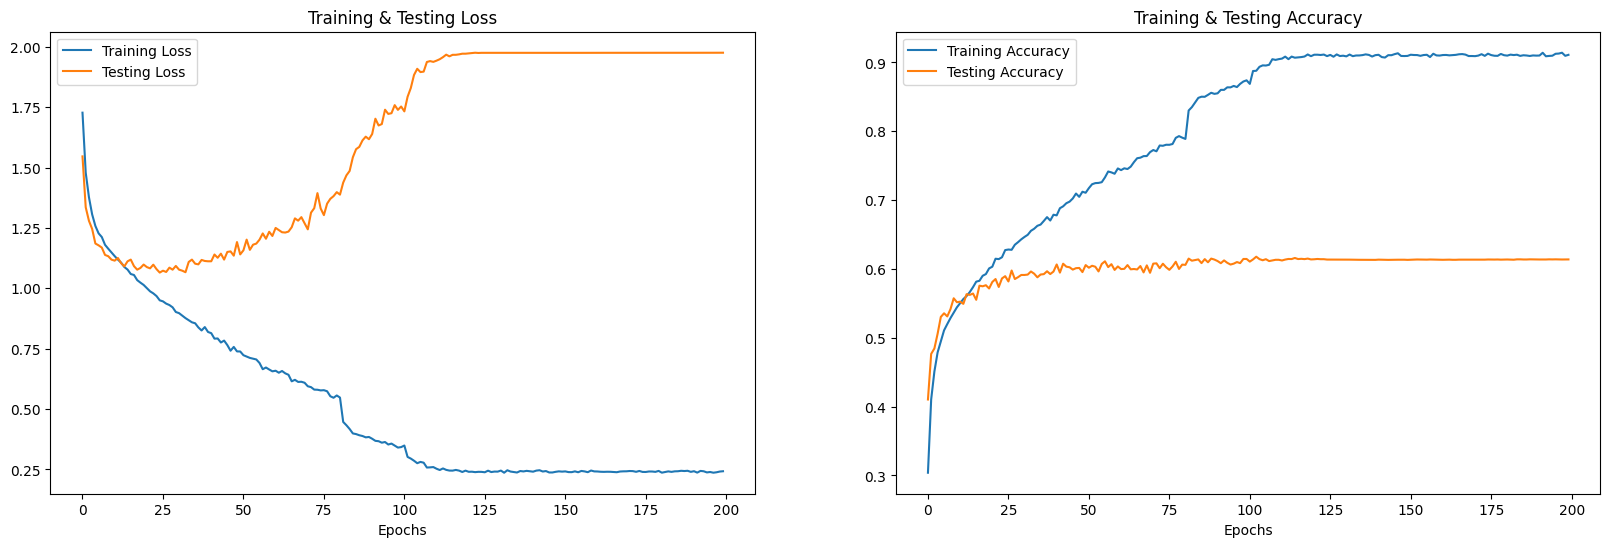

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 1s 3ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          neutral           sad
1             fear          fear
2            angry         angry
3              sad          fear
4          neutral       disgust
5            angry         angry
6            angry         happy
7            happy         happy
8             fear         angry
9         surprise      surprise

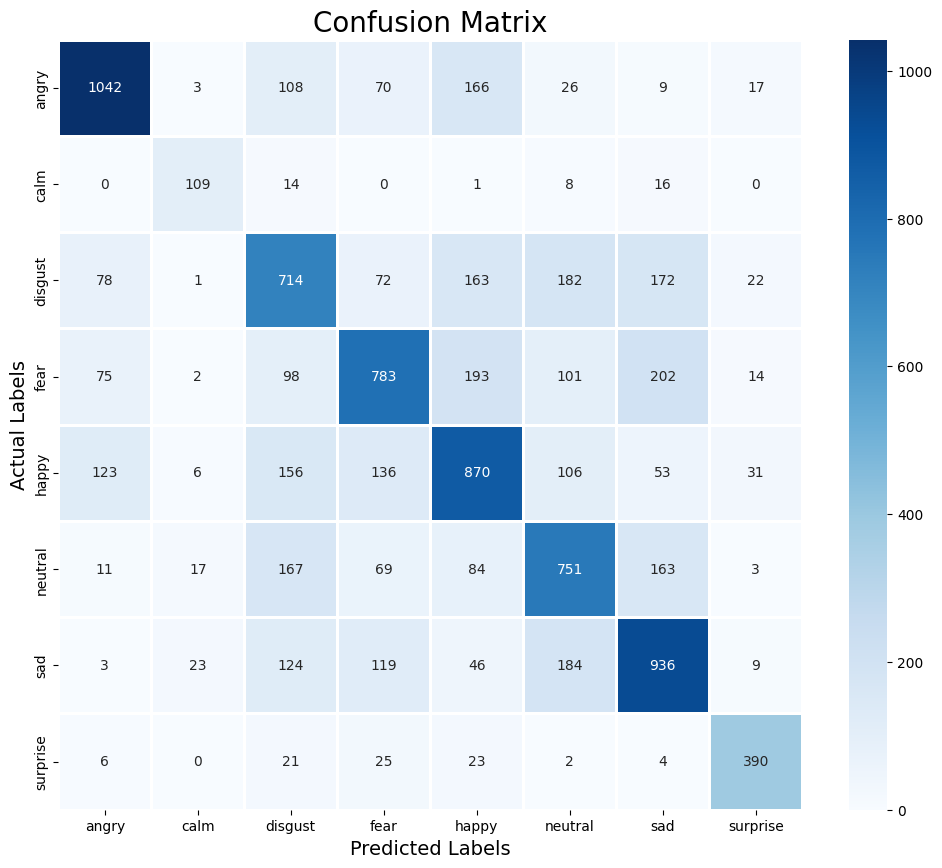

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.78      0.72      0.75      1441
        calm       0.68      0.74      0.71       148
     disgust       0.51      0.51      0.51      1404
        fear       0.61      0.53      0.57      1468
       happy       0.56      0.59      0.57      1481
     neutral       0.55      0.59      0.57      1265
         sad       0.60      0.65      0.62      1444
    surprise       0.80      0.83      0.82       471

    accuracy                           0.61      9122
   macro avg       0.64      0.64      0.64      9122
weighted avg       0.62      0.61      0.61      9122



In [ ]:
# Set the sample rate and duration
sr = 22050
duration = 5

# Define a function to extract features from the voice input
def extract_features(audio, sr):
    # Extract Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(audio, sr=sr, n_mfcc=20)
    # Flatten the matrix of MFCCs
    flattened = mfccs.flatten()
    # Return the flattened MFCCs
    return flattened.reshape(-1, 20)

# Define a function to predict the emotion from the voice input
def predict_emotion(audio):
    # Extract the features from the voice input
    features = extract_features(audio, sr)
    # Predict the emotion using the trained model
    prediction = model.predict(features)
    # Convert the prediction to an emotion label
    emotion = emotions[prediction.argmax()]
    # Return the emotion label
    return emotion

# Define a function to capture the voice input and output the predicted emotion
def process_voice_input():
    # Start recording the voice input
    print('Speak now...')
    audio = record_audio(duration, sr)
    # Predict the emotion from the voice input
    emotion = predict_emotion(audio)
    # Output the predicted emotion
    print('Emotion:', emotion)


In [ ]:
!pip install sounddevice

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sounddevice as sd

# Define a function to record audio
def record_audio(duration, sr):
    # Start recording audio
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait() # Wait for the recording to complete
    return audio.flatten()

# Call the process_voice_input function to capture voice input and output the predicted emotion
process_voice_input()

OSError: ignored

In [ ]:
# Define a function to capture the voice input and output the predicted emotion
def process_voice_input():
    # Start recording the voice input
    print('Speak now...')
    audio = record_audio(duration, sr)
    # Predict the emotion from the voice input
    emotion = predict_emotion(audio)
    # Output the predicted emotion
    print('Emotion:', emotion)

# Call the process_voice_input function to capture voice input and output the predicted emotion
process_voice_input()

Speak now...


NameError: ignored

#Interactive Audio

In [ ]:
!pip install pyaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PyAudio-0.2.13.tar.gz (46 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyaudio (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pyaudio
Failed to build pyaudio
ERROR: Could not build wheels for pyaudio, which is required to install pyproject.toml-based projects


In [ ]:
import pyaudio
import wave

# Set the duration of the recording in seconds
duration = 5

# Set the sampling rate and the size of each audio sample
sample_rate = 44100
sample_size = 2


ModuleNotFoundError: ignored

In [ ]:

# Initialize the PyAudio object
audio = pyaudio.PyAudio()

# Open a new audio stream for recording
stream = audio.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=sample_rate,
                    input=True,
                    frames_per_buffer=1024)

print('Recording started...')

# Record the audio for the specified duration
frames = []
for i in range(0, int(sample_rate / 1024 * duration)):
    data = stream.read(1024)
    frames.append(data)

print('Recording stopped.')

# Stop the recording and close the audio stream
stream.stop_stream()
stream.close()
audio.terminate()

# Save the recorded audio as a WAV file
filename = input('Enter the filename to save the recording: ')
wave_file = wave.open(filename, 'wb')
wave_file.setnchannels(1)
wave_file.setsampwidth(sample_size)
wave_file.setframerate(sample_rate)
wave_file.writeframes(b''.join(frames))
wave_file.close()

print(f'Recording saved as {filename}.')
